In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class
from GRF_perturbations.Modules.Image_processing import scipy_fit_image
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import Inference_class,infer_LogNorm_params
from GRF_perturbations.Modules.GRF_generation import get_Fourier_phase,get_k_grid

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Observation conditions

In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)
Inference=Inference_class(Observation_conditions)

del Observation_conditions_class
del Inference_class

Precomputing Fourier phases
Precompiling source-lens loss,gradient,hessian
Precomputing loss
Precomputing loss gradient
Precomputing loss hessian
Inference class is ready


## Unperturbed image

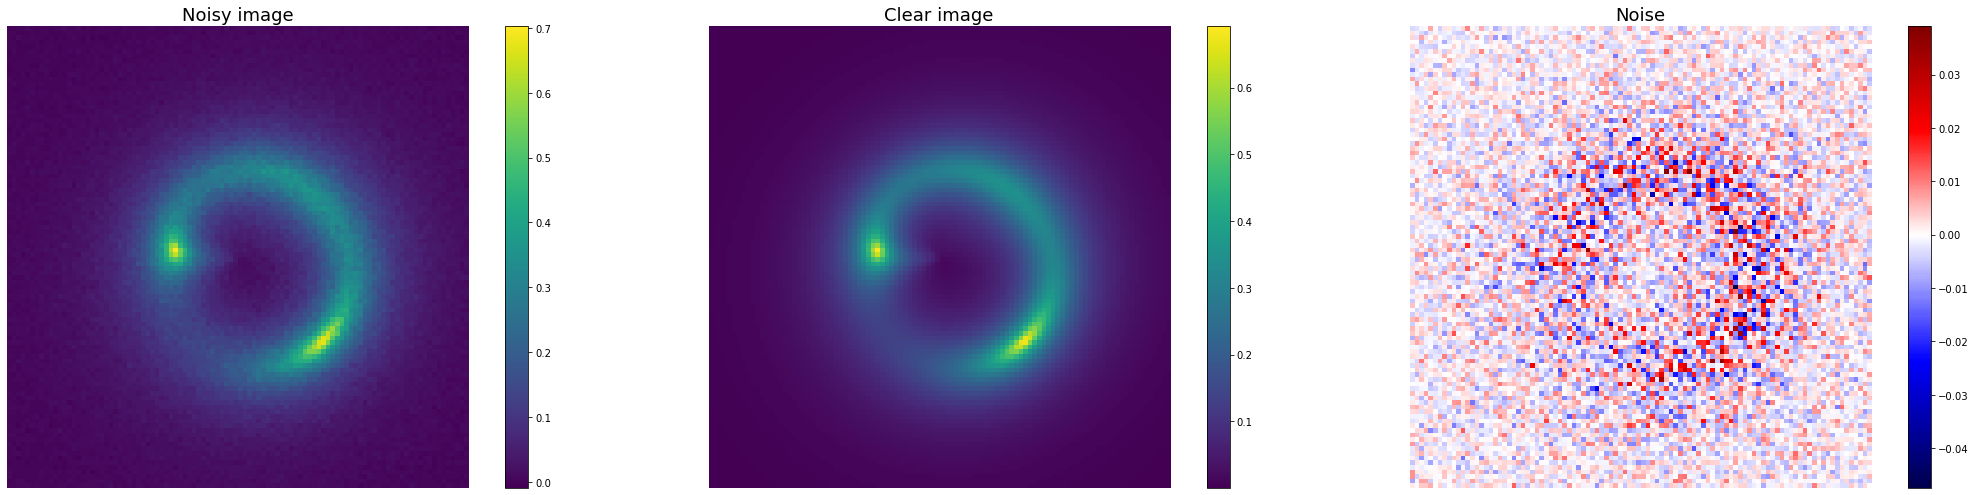

In [3]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)
Image_unperturbed_noisy=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=42)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(Image_unperturbed_noisy)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(Image_unperturbed_noisy-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

## Observed perturbed image

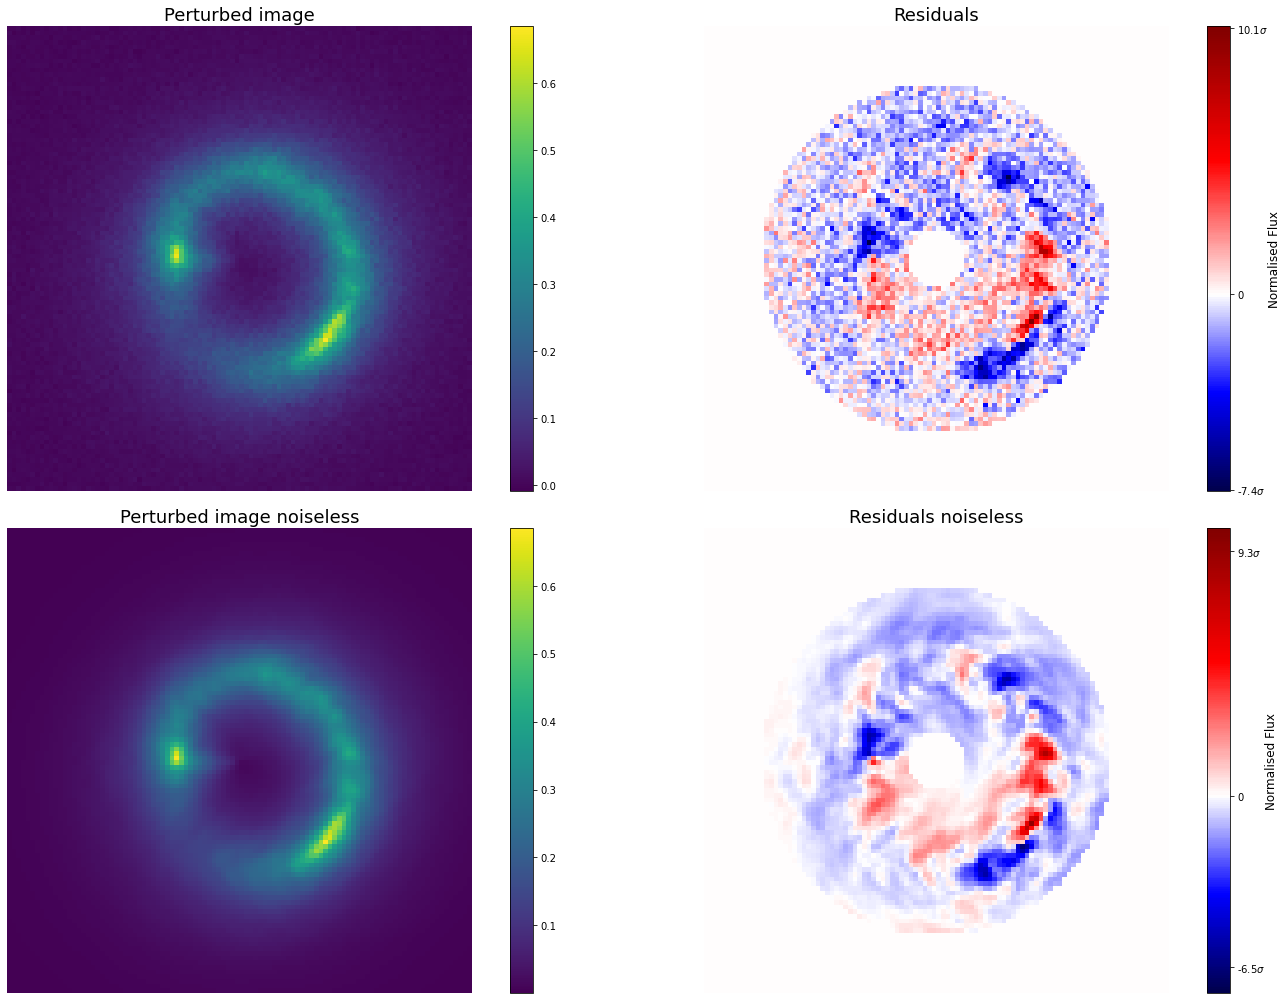

In [4]:
GRF_logA=-7.3
GRF_Beta=4.
GRF_seed_index=0

GRF_params=[GRF_logA,GRF_Beta]

get_GRF=Inference.GRF_getters()
GRF_potential=get_GRF(GRF_params,GRF_seed_index)
data_noise_seed=np.round(GRF_potential[0,0]*1e+10).astype(int)

simulate_perturbed_image=Observation_conditions.perturbed_image_getter
Image_perturbed_noiseless=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,Noise_flag=False)
Image_perturbed_noisy=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=data_noise_seed)

fig,ax=plt.subplots(2,2,figsize=(20,14))

images=np.array([[Image_perturbed_noisy,Image_perturbed_noisy-Image_unperturbed_noiseless],[Image_perturbed_noiseless,Image_perturbed_noiseless-Image_unperturbed_noiseless]])

#Normalized masked residuals
images[:,1]/=np.sqrt(Observation_conditions.noise_var)
images[:,1]*=Observation_conditions.annulus_mask


titles=np.array([['Perturbed image','Residuals'],['Perturbed image noiseless','Residuals noiseless']])

for i in range(2):
    axis_row=ax[i]
    img_arr=[]
    for j in range(2):
        axis=axis_row[j]
        image=images[i,j]
        title=titles[i,j]
        
        if j==0:
            img=axis.imshow(image)
            fig.colorbar(img,ax=axis)
        else:
            img=axis.imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,images[:,1].min(),images[:,1].max()))
            colorborders=[math.ceil(image.min()*1e+1)/1e+1,0,math.floor(image.max()*1e+1)/1e+1]
    
            cbar=fig.colorbar(img,ax=axis,ticks=colorborders,fraction=0.045)
            cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
            cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    
        axis.set_title(title,fontsize=FS)
        axis.axis('off')
plt.tight_layout()
plt.show()

# Data spectrum extraction

## Fit observed image to infer Source-Lens kwargs

In [5]:
args_fit=Inference.scipy_fit_image(Image_perturbed_noisy,method='trust-krylov',initial_values=Observation_conditions.parameters.initial_values())
fit_image=simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_fit),Noise_flag=False)

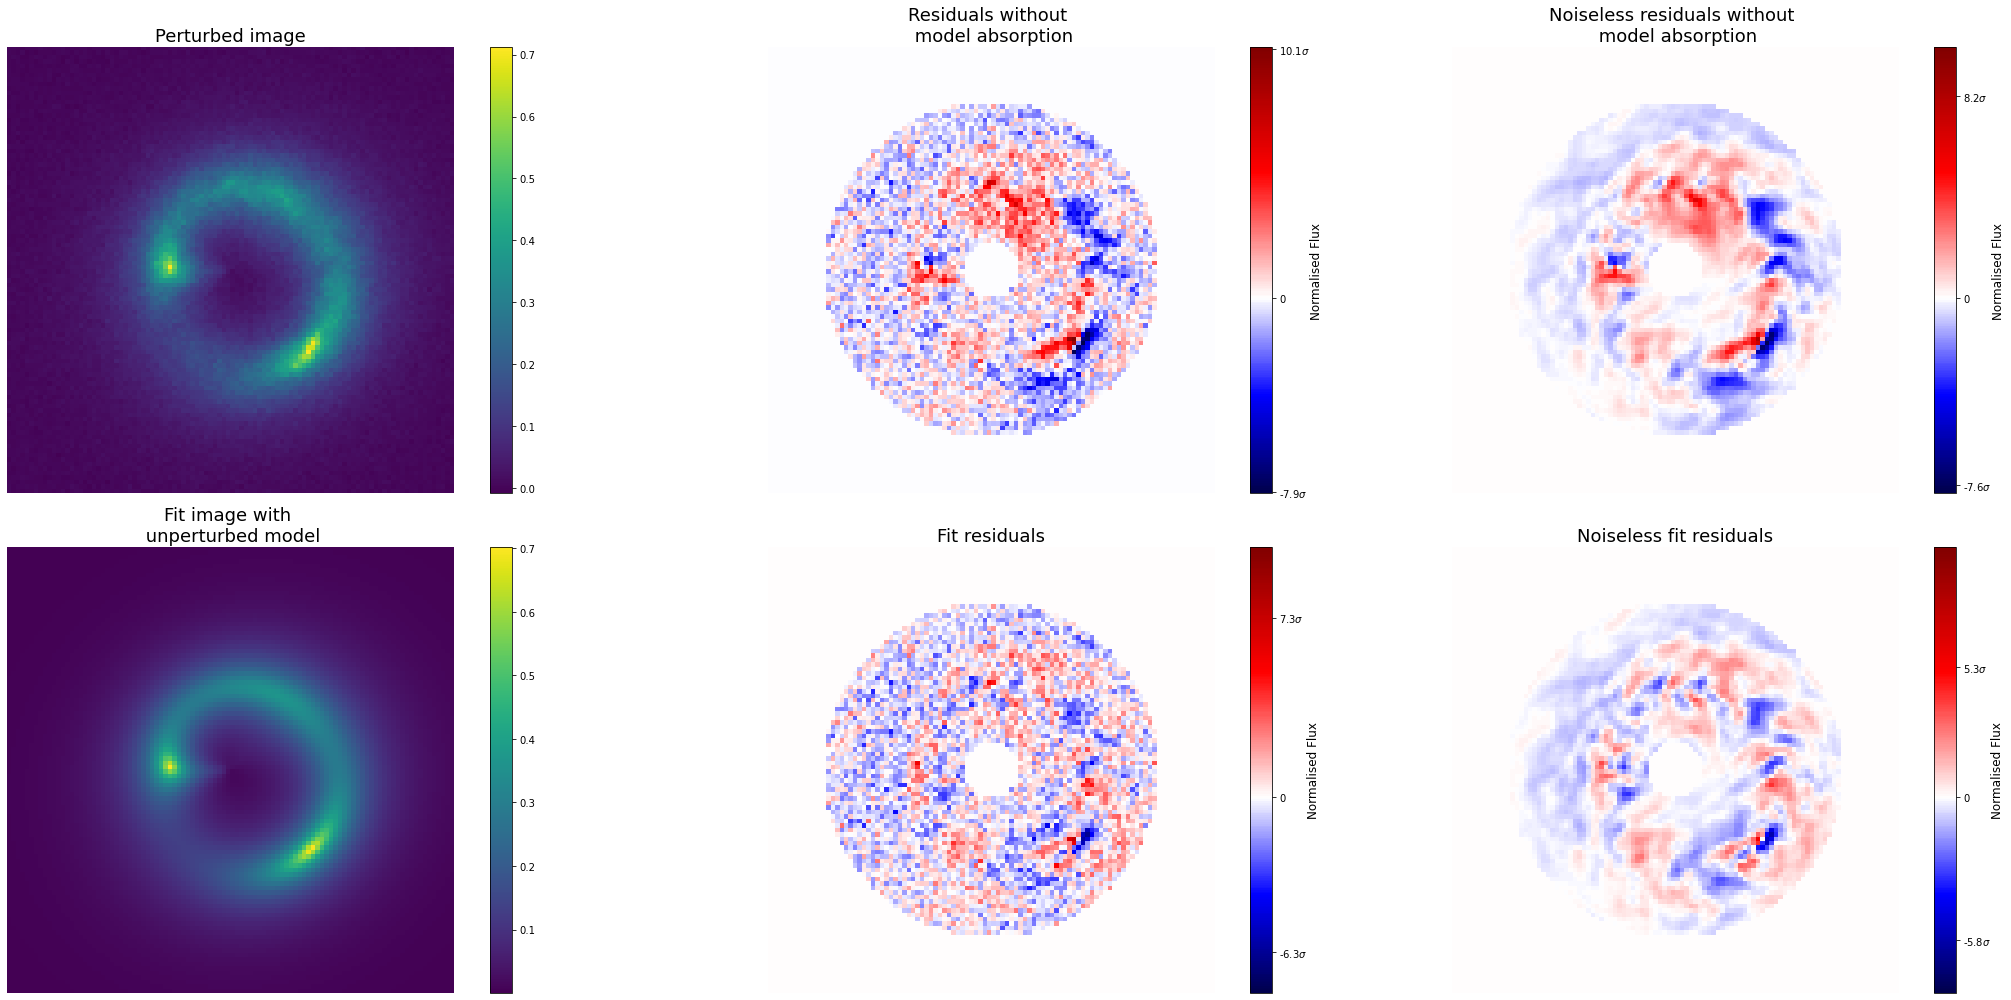

In [6]:
fig,ax=plt.subplots(2,3,figsize=(30,14))

images=np.array([[Image_perturbed_noisy,Image_perturbed_noisy-Image_unperturbed_noiseless,Image_perturbed_noiseless-Image_unperturbed_noiseless],\
                 [fit_image,Image_perturbed_noisy-fit_image,Image_perturbed_noisy-fit_image-(Image_perturbed_noisy-Image_perturbed_noiseless)]])

#Normalized masked residuals
images[:,1:]/=np.sqrt(Observation_conditions.noise_var)
images[:,1:]*=Observation_conditions.annulus_mask


titles=np.array([['Perturbed image','Residuals without \n model absorption','Noiseless residuals without \n model absorption'],\
                 ['Fit image with \n unperturbed model','Fit residuals','Noiseless fit residuals']])

for i in range(2):
    axis_row=ax[i]
    img_arr=[]
    for j in range(3):
        axis=axis_row[j]
        image=images[i,j]
        title=titles[i,j]
        
        if j==0:
            img=axis.imshow(image)
            fig.colorbar(img,ax=axis)
        else:
            img=axis.imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,images[:,1:].min(),images[:,1:].max()))
            colorborders=[math.ceil(image.min()*1e+1)/1e+1,0,math.floor(image.max()*1e+1)/1e+1]
    
            cbar=fig.colorbar(img,ax=axis,ticks=colorborders,fraction=0.045)
            cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
            cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    
        axis.set_title(title,fontsize=FS)
        axis.axis('off')
plt.tight_layout()
plt.show()

## Differentiable fit

In [9]:
args_dif_fit=Inference.differentiable_fit_image(Image_perturbed_noisy)
dif_fit_image=simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_dif_fit),Noise_flag=False)

Compilation took 35.10 seconds
How best fit loss would change if we change a pixel in fitted image?


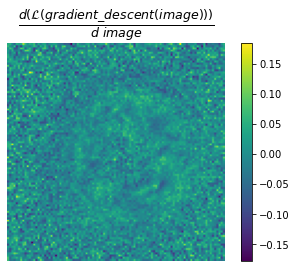

In [21]:
start_time=time.time()
dif_fit_pure=lambda image: Inference.image_loss(Inference.differentiable_fit_image(image,Observation_conditions.parameters.kwargs2args(Observation_conditions.kwargs_data)),image)
gradient_of_grad_descent=jax.grad(dif_fit_pure)(Image_perturbed_noisy)
print('Compilation took {:.2f} seconds'.format(time.time()-start_time))

print('How best fit loss would change if we change a pixel in fitted image?')

plt.imshow(gradient_of_grad_descent)
plt.colorbar()
plt.title(r'$\frac{d(\mathcal{L}(gradient\_descent(image)))}{d \ image}$',fontsize=FS)
plt.axis('off')
plt.show()

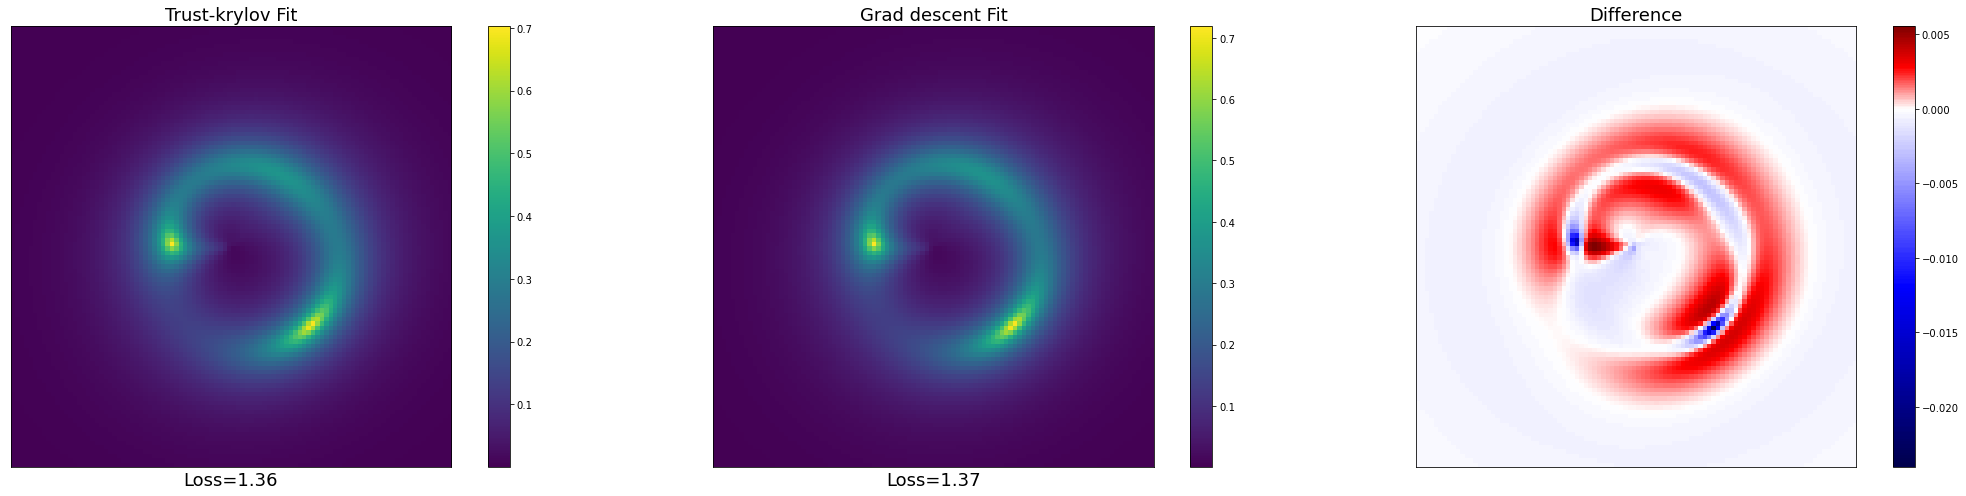

In [10]:
fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(fit_image)]
img_arr+=[ax[1].imshow(dif_fit_image)]
img_arr+=[ax[2].imshow(fit_image-dif_fit_image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Trust-krylov Fit','Grad descent Fit','Difference']

ax[0].set_xlabel('Loss={:.2f}'.format(Inference.image_loss(args_fit,Image_perturbed_noisy)),fontsize=FS)
ax[1].set_xlabel('Loss={:.2f}'.format(Inference.image_loss(args_dif_fit,Image_perturbed_noisy)),fontsize=FS)


for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.set_xticks([])
    axis.set_yticks([])
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

# Power spectrum generation

In [7]:
true_spectrum=Inference.compute_radial_spectrum(Image_perturbed_noisy-fit_image)
true_noise_spectrum=Inference.compute_radial_spectrum(Image_perturbed_noisy-Image_perturbed_noiseless)
Estimated_Noise_spectral_density=(Observation_conditions.noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()
frequencies=Observation_conditions.frequencies

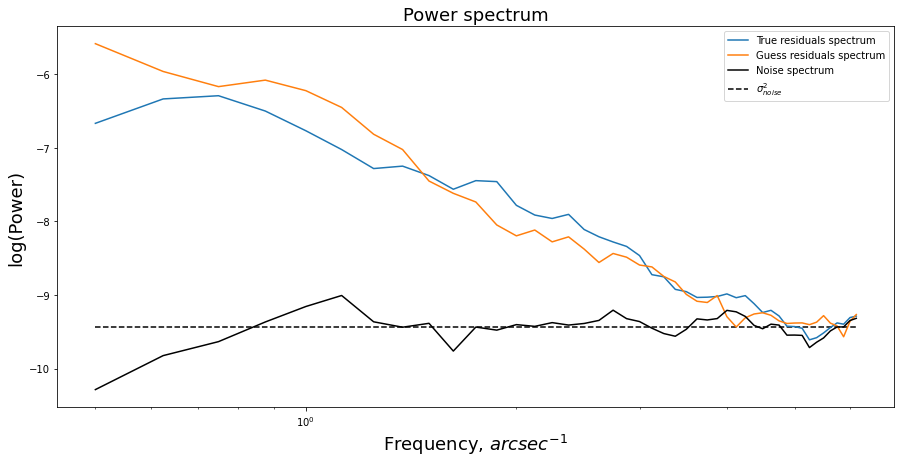

In [8]:
GRF_params_guess=[-7.3,4.]
Guess_spectrum=Inference.Residual_spectrum_for_GRF(GRF_params_guess,Inference.Fourier_phase_tensor[1],Noise=True)

plt.figure(figsize=(15,7))

plt.plot(frequencies,np.log(true_spectrum),label='True residuals spectrum')
plt.plot(frequencies,np.log(Guess_spectrum),label='Guess residuals spectrum')
plt.plot(frequencies,np.log(true_noise_spectrum),label='Noise spectrum',color='k')
plt.hlines(np.log(Estimated_Noise_spectral_density),frequencies[0],frequencies[-1],label=r'$\sigma^2_{noise}$',color='k',linestyle='--')


plt.xscale('log')

plt.ylabel('log(Power)',fontsize=FS)
plt.xlabel('Frequency, '+r'$arcsec^{-1}$',fontsize=FS)
plt.title('Power spectrum',fontsize=FS)

plt.legend()
plt.show()

# Power spectra distributions no Noise

In [5]:
import scipy
def lognormal(xdata,*params):
    amplitude,s,loc,scale=params
    x=(xdata-loc)/scale
    return amplitude*scipy.stats.lognorm.pdf(x,s)

def lognormal_2par(xdata,*params):
    amplitude,s,scale=params
    x=(xdata)/scale
    return amplitude*scipy.stats.lognorm.pdf(x,s)

def normal_distr(xdata,*params):
    amplitude,mean,sigma=params
    
    return amplitude*np.exp(-(xdata-mean)**2/2/sigma**2)

def fit_likelihood(xdata,ydata,distr_func='lognormal',multiplier=None,Poisson_errs=False):
    
    #It is a trick to fit distributions in very small numbers here scipy just sets everyrhing to zero
    if multiplier:
        x=multiplier*xdata
    else:
        non_zero_xdata=xdata[np.where(xdata>0)[0]]
        multiplier=1/non_zero_xdata[0]
        x=multiplier*xdata
        
    if distr_func=='lognormal':
        func=lognormal
        init_guess=[1,1.,0.,1]
    elif distr_func=='normal':
        func=normal_distr
        init_guess=[1,x.mean(),x.std()]
    elif distr_func=='lognormal2':
        func=lognormal_2par
        init_guess=[1,1.,1]
    else:
        print('wrong distr_func')
        return None
    
        
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess,sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess)

    
    if distr_func=='lognormal':
        amplitude,s,loc,scale=popt
        return amplitude,s,loc/multiplier,scale/multiplier
    if distr_func=='normal':
        amplitude,mean,sigma=popt
        return amplitude,mean/multiplier,sigma/multiplier
    if distr_func=='lognormal2':
        amplitude,s,scale=popt
        return amplitude,s,scale/multiplier

In [53]:
'''
Res_Spectra=np.zeros((300,len(frequencies)))

for i in tqdm(range(300)):
    Phase=get_Fourier_phase(100,i)
    Res_Spectra[i]=Inference.Residual_spectrum_for_GRF(GRF_params,Phase,Noise=True)
'''

100%|██████████████████████████████████████| 300/300 [23:53<00:00,  4.78s/it]


In [15]:
#Noise_spectra=jax_map(Inference.compute_radial_spectrum,np.array([np.random.normal(0,np.sqrt(Observation_conditions.noise_var)) for i in tqdm(range(10000))]))

100%|████████████████████████████████| 10000/10000 [00:02<00:00, 3921.33it/s]


In [6]:
#np.savez('./data/Dummy_spectra',Res_Spectra=Res_Spectra,clean_Res_spectra=clean_Res_Spectra,Noise_spectra=Noise_spectra)
arr=np.load('./data/Dummy_spectra.npz')
Res_Spectra=arr['Res_Spectra']
clean_Res_spectra=arr['clean_Res_spectra']
Noise_spectra=arr['Noise_spectra']

In [31]:
Noise_images=np.zeros((300,100,100))
Noise_spectra=np.zeros((300,100,100))

for i in tqdm(range(300)):
    Noise_images[i]=np.random.normal(0,np.sqrt(Observation_conditions.noise_var))*Observation_conditions.annulus_mask
    Noise_spectra[i]=np.abs(np.fft.fft(Noise_images[i]))**2

100%|███████████████████████████████████████| 300/300 [00:00<00:00, 2374.85it/s]


In [27]:
plt.imshow(np.random.normal(0,np.sqrt(Observation_conditions.noise_var))*Observation_conditions.annulus_mask,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [49]:
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)

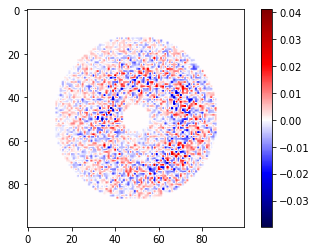

In [11]:
q=np.random.normal(0,np.sqrt(Image_unperturbed_noiseless/2028))
masked_q=q*Observation_conditions.annulus_mask
plt.imshow(masked_q,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

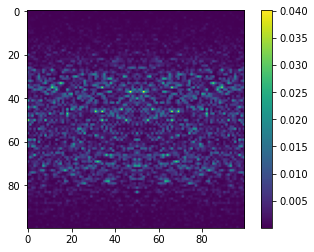

In [12]:
plt.imshow(np.abs(np.fft.fft(q))**2)
plt.colorbar()

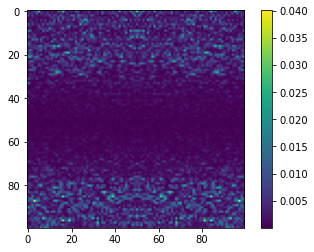

In [13]:
plt.imshow(np.fft.fftshift(np.abs(np.fft.fft(q))**2))
plt.colorbar()

In [20]:
p=np.abs(np.fft.fft(q))**2

In [16]:
np.fft.fftshift(np.fft.fftfreq(100))

array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
        0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
        0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
        0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
        0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
        0.45,  0.46,  0.47,  0.48,  0.49, -0.5 , -0.49, -0.48, -0.47,
       -0.46, -0.45, -0.44, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38,
       -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29,
       -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 ,
       -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01])

In [23]:
np.fft.fftfreq(100)

array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
        0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
        0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
        0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
        0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
        0.45,  0.46,  0.47,  0.48,  0.49, -0.5 , -0.49, -0.48, -0.47,
       -0.46, -0.45, -0.44, -0.43, -0.42, -0.41, -0.4 , -0.39, -0.38,
       -0.37, -0.36, -0.35, -0.34, -0.33, -0.32, -0.31, -0.3 , -0.29,
       -0.28, -0.27, -0.26, -0.25, -0.24, -0.23, -0.22, -0.21, -0.2 ,
       -0.19, -0.18, -0.17, -0.16, -0.15, -0.14, -0.13, -0.12, -0.11,
       -0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
       -0.01])

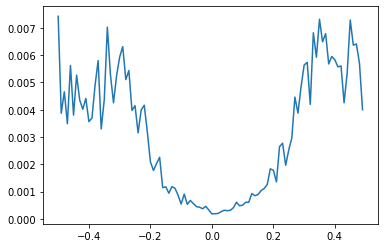

In [30]:
plt.plot(np.fft.fftshift(np.fft.fftfreq(100)),np.fft.fftshift(p.mean(axis=1)))

In [32]:
1/(0.08*100)

0.125

In [35]:
1/0.2

5.0

In [36]:
1/0.4

2.5

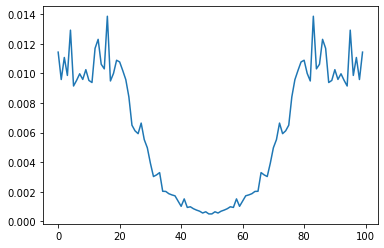

In [17]:
l=p.mean(axis=1)
l+=l[::-1]
plt.plot(l)

In [174]:
Anomalies_images=np.zeros((300,100,100))
Anomalies_spectra=np.zeros((300,100,100))
get_GRF=Inference.GRF_getters(False)

GRF_params=[-7,4]
simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
for i in tqdm(range(300)):
    
    Phase=get_Fourier_phase(100,i)
    GRF_potential=get_GRF(GRF_params,Phase)
    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(i+1)*1e+5)).astype(int)
    simulated_image=simulate_perturbed_image(GRF_potential,Inference.Observation_conditions.kwargs_data,True,noise_seed)
    Anomalies_images[i]=simulated_image-Image_unperturbed_noiseless
    Anomalies_spectra[i]=np.abs(np.fft.fft(Anomalies_images[i]))**2

100%|███████████████████████████████████████████████████████| 300/300 [00:07<00:00, 39.08it/s]


In [173]:
simulate_perturbed_image??

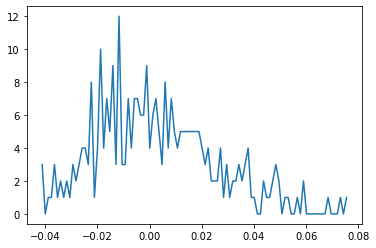

In [76]:
data,x=np.histogram(Anomalies_images[:,41,41],bins=100)
plt.plot(x[1:],data)

In [48]:
Anomalies_images[i][40,40]

0.0050538793744216715

In [79]:
import imutils

ModuleNotFoundError: No module named 'imutils'

In [7]:
import scipy as sc
def map_spec_to_radial(Spectrum,k_grid):
    
    k_values=np.arange(0,np.abs(np.fft.fftfreq(100,0.08)).max(),0.125)
    radial_spectrum=np.zeros_like(k_values)
    radial_errorbars=np.zeros((2,len(k_values)))
    counts=np.zeros_like(k_values)
    
    for i in range(1,len(k_values)):
        mask=(k_grid>=k_values[i-1])&(k_grid<k_values[i])
        radial_spectrum[i]=Spectrum[mask].sum()/mask.sum()
        radial_errorbars[0,i]=radial_spectrum[i]-Spectrum[mask].min()
        radial_errorbars[1,i]=Spectrum[mask].max()-radial_spectrum[i]
        counts[i]=mask.sum()
        
    return k_values,radial_spectrum,radial_errorbars,counts

import scipy



def lognormal(xdata,*params):
    s,loc,scale=params
    #x=(xdata-loc)/scale
    return scipy.stats.lognorm.pdf(x,s,loc=loc,scale=scale)

def lognormal_2par(xdata,*params):
    s,scale=params
    x=(xdata)/scale
    return scipy.stats.lognorm.pdf(x,s)

def normal_distr(xdata,*params):
    mean,sigma=params
    
    return np.exp(-(xdata-mean)**2/2/sigma**2)

def chi2_distr(xdata,*params):
    scale=params
    
    distr=sc.stats.chi2.pdf(xdata,df=2,loc=0,scale=scale)
    
    return distr/distr.sum()

def chi2_noncent_1df(xdata,*params):
    nc,scale=params
    return sc.stats.ncx2.pdf(xdata,df=1,nc=nc,loc=0,scale=scale)
    

def fit_likelihood(xdata,ydata,distr_func='lognormal',multiplier=None,Poisson_errs=False):
    
    #It is a trick to fit distributions in very small numbers here scipy just sets everyrhing to zero
    if multiplier:
        x=multiplier*xdata
    else:
        non_zero_xdata=xdata[np.where(xdata>0)[0]]
        multiplier=1/non_zero_xdata[0]
        x=multiplier*xdata
        
    if distr_func=='lognormal':
        func=lognormal
        init_guess=[1.,0.,1]
    elif distr_func=='normal':
        func=normal_distr
        init_guess=[x.mean(),x.std()]
    elif distr_func=='chi2':
        func=chi2_distr
        init_guess=[1]
    elif distr_func=='nc_chi2':
        func=chi2_noncent_1df
        init_guess=[1,1]
    elif distr_func=='lognormal2':
        func=lognormal_2par
        init_guess=[1.,1]
    else:
        print('wrong distr_func')
        return None
    
        
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess,sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess)

    
    if distr_func=='lognormal':
        s,loc,scale=popt
        return s,loc/multiplier,scale/multiplier
    if distr_func=='normal':
        amplitude,mean,sigma=popt
        return amplitude,mean/multiplier,sigma/multiplier
    if distr_func=='lognormal2':
        amplitude,s,scale=popt
        return amplitude,s,scale/multiplier
    if distr_func=='chi2':
        scale=popt
        return 2,0,scale/multiplier
    if distr_func=='nc_chi2':
        nc,scale=popt
        return 1,nc/multiplier**2,0,scale/multiplier

Looks like chi2 distribution

In [8]:
Anomalies_images=np.zeros((10000,100,100))
Anomalies_spectra=np.zeros((10000,100,100))
get_GRF=Inference.GRF_getters(False)

GRF_params=[-7,2]
simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
for i in tqdm(range(10000)):
    
    Phase=get_Fourier_phase(100,i)
    GRF_potential=get_GRF(GRF_params,Phase)
    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(i+1)*1e+5)).astype(int)
    simulated_image=simulate_perturbed_image(GRF_potential,Inference.Observation_conditions.kwargs_data,False,noise_seed)
    Anomalies_images[i]=simulated_image-Image_unperturbed_noiseless
    Anomalies_spectra[i]=np.abs(np.fft.fft(Anomalies_images[i]))**2

100%|██████████████████████████████████| 10000/10000 [06:17<00:00, 26.50it/s]


In [7]:
#np.savez('./data/Anomalies_images',Anomalies_images)

In [9]:
import scipy as sc

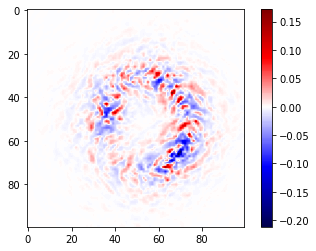

In [9]:
plt.imshow(Anomalies_images[4],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

1.2855563896652185e-05
1.434005278748984e-188


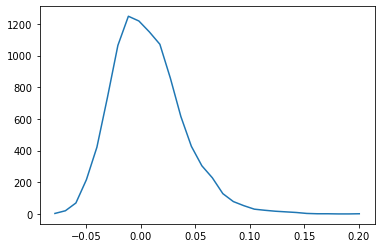

In [10]:
i=40
j=40
data,x=np.histogram(Anomalies_images[:,i,j],bins=30)
plt.plot(x[1:],data)
print(sc.stats.ttest_1samp(Anomalies_images[:,i,j],0,alternative='two-sided')[1])
print(sc.stats.normaltest(Anomalies_images[:,i,j]/Anomalies_images[:,i,j].std())[1])


In [11]:
spectra=np.fft.fft(Anomalies_images)

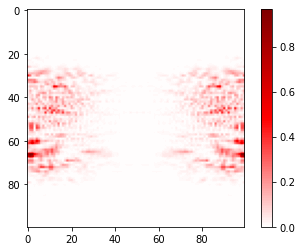

In [12]:
plt.imshow(np.abs(spectra[4])**2,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

0.6403478601385487
0.007048508335808851


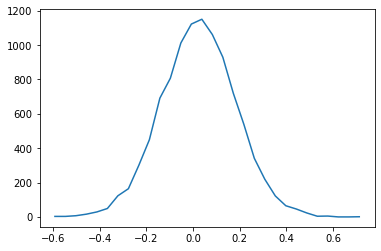

In [13]:
i=40
j=20
data,x=np.histogram(spectra[:,i,j].real,bins=30)
plt.plot(x[1:],data)
print(sc.stats.ttest_1samp(spectra[:,i,j].real,0,alternative='two-sided')[1])
print(sc.stats.normaltest(spectra[:,i,j].real)[1])



0.2658752366533407
0.0002054865107819336


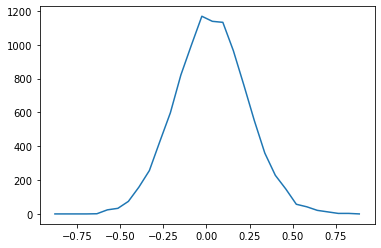

In [14]:
i=40
j=10
data,x=np.histogram(spectra[:,i,j].imag,bins=30)
plt.plot(x[1:],data)
print(sc.stats.ttest_1samp(spectra[:,i,j].imag,0,alternative='two-sided')[1])
print(sc.stats.normaltest(spectra[:,i,j].imag)[1])


In [15]:
spectra.real.shape

(10000, 100, 100)

In [20]:
corr_matr=np.corrcoef(spectra.real.reshape((10000,10000)),rowvar=False)

In [ ]:
spectra.real.std(axis=0)

In [21]:
corr_matr

array([[ 1.        , -0.76654554,  0.14950585, ...,  0.00685965,
         0.00199396, -0.02771445],
       [-0.76654554,  1.        , -0.53945404, ...,  0.01053516,
        -0.03827377,  0.05454558],
       [ 0.14950585, -0.53945404,  1.        , ..., -0.07614386,
         0.10721741, -0.05178268],
       ...,
       [ 0.00685965,  0.01053516, -0.07614386, ...,  1.        ,
        -0.66881987,  0.21940797],
       [ 0.00199396, -0.03827377,  0.10721741, ..., -0.66881987,
         1.        , -0.63633505],
       [-0.02771445,  0.05454558, -0.05178268, ...,  0.21940797,
        -0.63633505,  1.        ]])

In [27]:
corr_matr.shape

(10000, 10000)

In [30]:
np.argmax(corr_matr)

0

In [56]:
spectra.real[:,0,0]

array([-0.00419581,  0.02340017,  0.01916057, ...,  0.0089197 ,
        0.01313727,  0.01268646])

In [57]:
spectra.imag[:,0,0]

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
np.correlate(spectra.real[:,0,0],spectra.real[:,1,1])

array([-0.41413302])

In [75]:
def corr_matrix(tensor1,tensor2):
    corrs=np.zeros((tensor1.shape[-2],tensor1.shape[-1]))
    pvals=np.zeros((tensor1.shape[-2],tensor1.shape[-1]))
    
    for i in tqdm(range(tensor1.shape[-2])):
        for j in range(tensor1.shape[-1]):
            res=sc.stats.pearsonr(tensor1[:,i,j],tensor2[:,i,j])
            corrs[i,j]=res[0]
            pvals[i,j]=res[1]
            
    return corrs,pvals

In [76]:
Rs,pvals=corr_matrix(spectra.real,spectra.imag)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.57it/s]


In [64]:
sc.stats.pearsonr(spectra.real[:,i,j],tensor2.imag[:,i,j])

nan

In [66]:
Rs

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

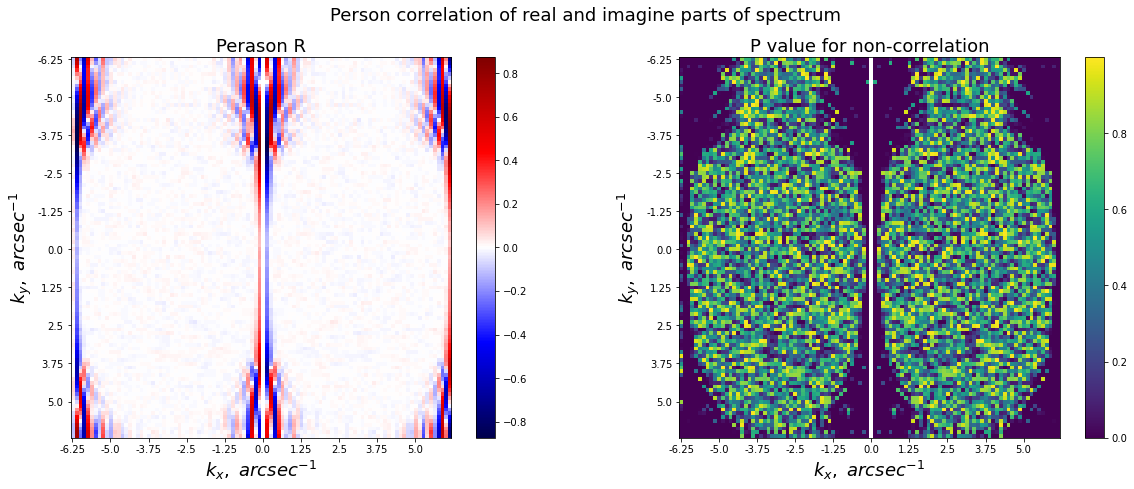

In [86]:
k_vector=np.fft.fftfreq(100,0.08)
fig,ax=plt.subplots(1,2,figsize=(20,7))

im=ax[0].imshow(np.fft.fftshift(Rs),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[0].set_title('Perason R',fontsize=FS)
fig.colorbar(im,ax=ax[0])

im=ax[1].imshow(np.fft.fftshift(pvals))
ax[1].set_title('P value for non-correlation',fontsize=FS)
fig.colorbar(im,ax=ax[1])

for i in range(2):
    ax[i].set_yticks(np.arange(0,len(k_vector),10))
    ax[i].set_xticks(np.arange(0,len(k_vector),10))
    ax[i].set_yticklabels(np.fft.fftshift(k_vector)[::10])
    ax[i].set_xticklabels(np.fft.fftshift(k_vector)[::10])
    ax[i].set_ylabel(r'$k_y, \ arcsec^{-1}$',fontsize=FS)
    ax[i].set_xlabel(r'$k_x, \ arcsec^{-1}$',fontsize=FS)
    
    
fig.suptitle('Person correlation of real and imagine parts of spectrum',fontsize=FS)
plt.show()

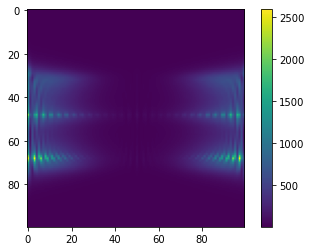

In [26]:
plt.imshow(correlation_matrix)
plt.colorbar()

In [18]:
spectra.real.T.reshape((10000,10000))

(100, 100, 10000)

In [129]:
scale_estimates=Anomalies_spectra.sum(axis=0)/100/100

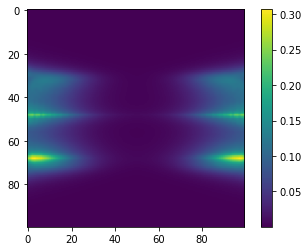

In [130]:
plt.imshow(scale_estimates)
plt.colorbar()

In [177]:
normalisations=np.zeros_like(scale_estimates)
for i in range(100):
    for j in range(100):
        normalisations[i,j]=np.sum(sc.stats.gamma.pdf(Anomalies_spectra[:,i,j],a=1,loc=0,scale=scale_estimates[i,j]))

Text(0, 0.5, 'Number density')

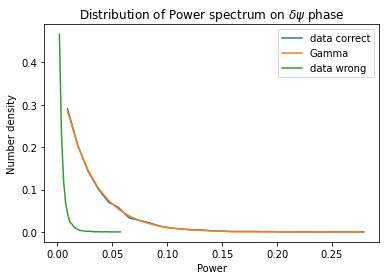

In [204]:
i=50
j=30

data,x=np.histogram(Anomalies_spectra[:,i,j],bins=30)
data_wrong,x_wrong=np.histogram(Anomalies_spectra_4[:,i,j],bins=30)

distribution = "gamma"
distr = getattr(sc.stats, distribution)
params = distr.fit(data,fa=1)


m=sc.stats.gamma.pdf(x[1:],a=1,loc=0,scale=scale_estimates[i,j])

plt.plot(x[1:],data/data.sum(),label='data correct')
plt.plot(x[1:],m/m.sum(),label='Gamma')
plt.plot(x_wrong[1:],data_wrong/data_wrong.sum(),label='data wrong')

plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')

In [255]:
spectra=np.fft.fft(Anomalies_images)

In [260]:
np.abs(spectra[0]).max()

1.1634603526797282

In [268]:
(np.abs(spectra[:,:,0].imag)<1e-16).all()

True

In [267]:
(spectra[:,:,50].imag<1e-16).all()

False

In [272]:
np.unique(np.where((np.abs(spectra[:,:,50].imag)>1e-13))[1])

array([], dtype=int64)

In [264]:
spectra[:,:,50]

array([[-6.18974343e-04+2.16840434e-19j,  5.94872514e-04-4.33680869e-19j,
         5.59227824e-04-4.33680869e-19j, ...,
         1.00922906e-04-8.67361738e-19j, -4.03737811e-03+0.00000000e+00j,
        -6.63368435e-03+0.00000000e+00j],
       [-1.09162036e-04+2.16840434e-19j, -9.33005181e-04-3.25260652e-19j,
         3.05250785e-04-7.58941521e-19j, ...,
         9.48965995e-04+0.00000000e+00j, -4.05461325e-04-5.42101086e-20j,
        -1.89986316e-03+1.08420217e-18j],
       [ 5.63814859e-03+2.16840434e-19j,  2.39959557e-03-4.33680869e-19j,
        -1.31543329e-03-4.33680869e-19j, ...,
        -8.83122063e-04+1.08420217e-18j, -2.26254505e-04+8.67361738e-19j,
        -3.10002208e-03+1.30104261e-18j],
       ...,
       [-4.27809339e-03-8.67361738e-19j, -2.57231885e-03-2.16840434e-19j,
        -1.51530942e-03+1.30104261e-18j, ...,
        -5.21194818e-03+4.33680869e-19j, -2.55355346e-04+0.00000000e+00j,
         6.57643441e-03-8.67361738e-19j],
       [-3.60919277e-04+0.00000000e+00j, -5.

In [265]:
np.where((np.abs(spectra[:,:,0].imag)<1e-16))

(array([   0,    0,    0, ..., 9999, 9999, 9999]),
 array([ 0,  1,  2, ..., 97, 98, 99]))

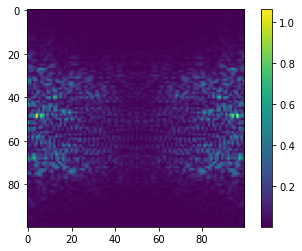

In [257]:
plt.imshow(np.abs(spectra[0,:,:].real))
plt.colorbar()

In [242]:
spectra[:,0,0]

array([-0.00419581+0.j,  0.02340017+0.j,  0.01916057+0.j, ...,
        0.0089197 +0.j,  0.01313727+0.j,  0.01268646+0.j])

In [205]:
x_wrong

array([4.66241494e-08, 1.91148897e-03, 3.82293131e-03, 5.73437366e-03,
       7.64581601e-03, 9.55725835e-03, 1.14687007e-02, 1.33801430e-02,
       1.52915854e-02, 1.72030277e-02, 1.91144701e-02, 2.10259124e-02,
       2.29373548e-02, 2.48487971e-02, 2.67602395e-02, 2.86716818e-02,
       3.05831241e-02, 3.24945665e-02, 3.44060088e-02, 3.63174512e-02,
       3.82288935e-02, 4.01403359e-02, 4.20517782e-02, 4.39632206e-02,
       4.58746629e-02, 4.77861053e-02, 4.96975476e-02, 5.16089899e-02,
       5.35204323e-02, 5.54318746e-02, 5.73433170e-02])

In [ ]:
i=50
j=30




distribution = "gamma"
distr = getattr(sc.stats, distribution)
params = distr.fit(data,fa=1)


m=sc.stats.gamma.pdf(x[1:],a=1,loc=0,scale=scale_estimates[i,j])

#plt.plot(x[1:],data/data.sum(),label='data')
plt.plot(x[1:],m,label='Gamma')


plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')

In [195]:
def prob(x,scale,normalisations,a=1,loc=0):
    return -sc.stats.gamma.logpdf(x,a=a,loc=loc,scale=scale)

In [196]:
spec=deepcopy(Anomalies_spectra[-1,:,:])
logpdf=prob(spec[i,j],scale_estimates,normalisations)

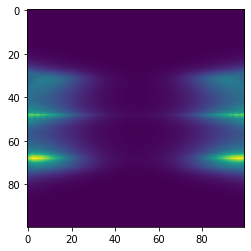

In [197]:
plt.imshow(scale_estimates)

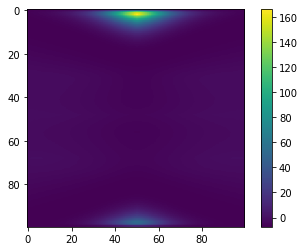

In [198]:
plt.imshow(logpdf)
plt.colorbar()

In [199]:
logpdf.mean()

-1.970966275484435

In [200]:
spec=deepcopy(Anomalies_spectra_4[-1,:,:])
logpdf=prob(spec[i,j],scale_estimates,normalisations)

In [201]:
logpdf.mean()

-2.451444971762806

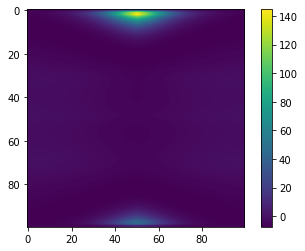

In [202]:
plt.imshow(logpdf)
plt.colorbar()

In [171]:
prob(spec,scale_estimates)

array([[ 2148.41488571,  4228.07817085,  1584.47908076, ...,
         2229.66737491,  1584.47908076,  4228.07817085],
       [   53.5915616 ,  1285.09840707,  7954.65227321, ...,
         5129.03789942,  7954.65227321,  1285.09840707],
       [   18.01318444,  1122.81121994, 11447.65605433, ...,
        15357.90630207, 11447.65605433,  1122.81121994],
       ...,
       [ 4261.84159563,  3493.05720897,   547.81982839, ...,
         1587.92527603,   547.81982839,  3493.05720897],
       [  934.45709995,  3287.41843408,  1451.71094906, ...,
         2121.40226608,  1451.71094906,  3287.41843408],
       [  451.81567901,  1602.93934632,  2725.81371229, ...,
         3062.77968575,  2725.81371229,  1602.93934632]])

In [150]:
sc.stats.gamma.cdf(1,a=1,loc=0,scale=1)

0.6321205588285577

In [164]:
m

array([2.57962277e+01, 1.84458962e+01, 1.31899552e+01, 9.43163268e+00,
       6.74419995e+00, 4.82251954e+00, 3.44839935e+00, 2.46581854e+00,
       1.76321257e+00, 1.26080590e+00, 9.01554095e-01, 6.44666866e-01,
       4.60976629e-01, 3.29626764e-01, 2.35703497e-01, 1.68542559e-01,
       1.20518341e-01, 8.61780578e-02, 6.16226344e-02, 4.40639900e-02,
       3.15084746e-02, 2.25305056e-02, 1.61107032e-02, 1.15201479e-02,
       8.23761734e-03, 5.89040522e-03, 4.21200358e-03, 3.01184273e-03,
       2.15365359e-03, 1.53999534e-03])

Text(0, 0.5, 'Number density')

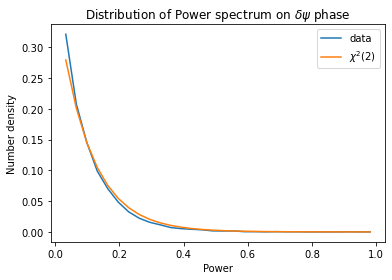

In [90]:
i=40
j=10

q=spectra[:,i,j]
p=(q.real/q.real.std())**2+(q.imag/q.imag.std())**2
data,x=np.histogram(np.abs(q)**2,bins=30)

norm_data=data/data.sum()

popt=fit_likelihood(x[1:],norm_data,distr_func='chi2',Poisson_errs=False)



distribution = "chi2"
distr = getattr(sc.stats, distribution)
params = distr.fit(norm_data)

l=sc.stats.chi2.pdf(x[1:],df=2,loc=0,scale=0.05)
m=sc.stats.chi2.pdf(x[1:],df=popt[0],loc=popt[1],scale=popt[2])

plt.plot(x[1:],norm_data,label='data')
plt.plot(x[1:],l/l.sum(),label=r'$\chi^2(2)$')
#plt.plot(x[1:],m/m.sum(),label=r'$\chi^2$'+' fit')
plt.legend()
plt.title('Distribution of Power spectrum on '+r'$\delta \psi$'+' phase')
plt.xlabel('Power')
plt.ylabel('Number density')

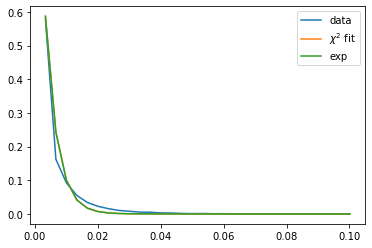

In [242]:
i=50
j=50

q=spectra[:,i,j]
p=(q.real/q.real.std())**2+(q.imag/q.imag.std())**2
data,x=np.histogram(np.abs(q)**2,bins=30)

norm_data=data/data.sum()

popt=fit_likelihood(x[1:],norm_data,distr_func='chi2',Poisson_errs=False)



distribution = "chi2"
distr = getattr(sc.stats, distribution)
params = distr.fit(norm_data)

l=np.exp(-x[1:]/(popt[2]*2))
m=sc.stats.chi2.pdf(x[1:],df=popt[0],loc=popt[1],scale=popt[2])

plt.plot(x[1:],norm_data,label='data')
#plt.plot(x[1:],l/l.sum(),label=r'$\chi^2$')
plt.plot(x[1:],m/m.sum(),label=r'$\chi^2$'+' fit')
plt.plot(x[1:],l/l.sum(),label='exp')


plt.legend()



In [243]:
popt[2]

array([0.00188521])

In [246]:
l.sum()

0.7025612726873751

In [187]:
error_map=np.zeros((100,100))

for i in tqdm(range(100)):
    for j in range(100):
        data,x=np.histogram(Anomalies_spectra[:,i,j],bins=30)
        norm_data=data/data.sum()
        popt=fit_likelihood(x[1:],norm_data,distr_func='chi2',Poisson_errs=False)
        error_map[i,j]=popt[2]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.59it/s]


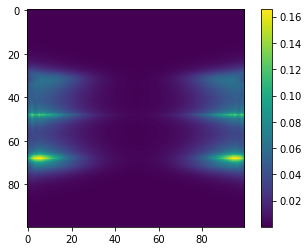

In [189]:
plt.imshow(error_map)
plt.colorbar()

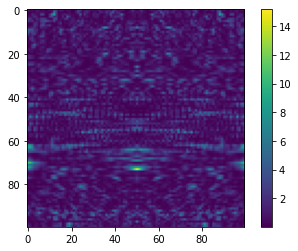

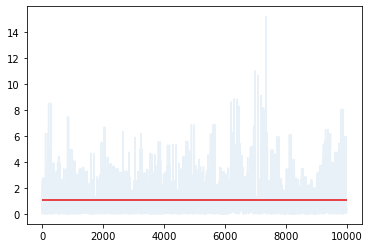

In [216]:
i=7
plt.imshow(Anomalies_spectra[i]/error_map/2)
plt.colorbar()
plt.show()
plt.plot((Anomalies_spectra[i]/error_map/2).ravel(),alpha=0.1)
plt.hlines((Anomalies_spectra[i]/error_map/2).mean(),0,10000,color='r')
plt.show()

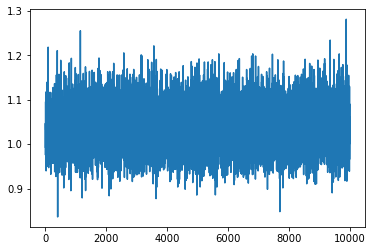

In [217]:
plt.plot((Anomalies_spectra/error_map/2).mean(axis=(1,2)))

In [176]:
Anomalies_images_4=np.zeros((10000,100,100))
Anomalies_spectra_4=np.zeros((10000,100,100))
get_GRF=Inference.GRF_getters(False)

GRF_params=[-7,4]
simulate_perturbed_image=Inference.Observation_conditions.perturbed_image_getter
for i in tqdm(range(10000)):
    
    Phase=get_Fourier_phase(100,i)
    GRF_potential=get_GRF(GRF_params,Phase)
    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(i+1)*1e+5)).astype(int)
    simulated_image=simulate_perturbed_image(GRF_potential,Inference.Observation_conditions.kwargs_data,False,noise_seed)
    Anomalies_images_4[i]=simulated_image-Image_unperturbed_noiseless
    Anomalies_spectra_4[i]=np.abs(np.fft.fft(Anomalies_images_4[i]))**2

100%|██████████████████████████████████| 10000/10000 [06:21<00:00, 26.23it/s]


In [227]:
error_map_4=np.zeros((100,100))

for i in tqdm(range(100)):
    for j in range(100):
        data,x=np.histogram(Anomalies_spectra_4[:,i,j],bins=30)
        norm_data=data/data.sum()
        popt=fit_likelihood(x[1:],norm_data,distr_func='chi2',Poisson_errs=False)
        error_map_4[i,j]=popt[2]

 31%|███████████████████████████████████████████████████▍                                                                                                                  | 31/100 [00:02<00:05, 13.37it/s]/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 43/100 [00:03<00:04, 13.61it/s]/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_32361/3309480665.py:42: RuntimeWarning: invalid value encountered in true_divide
  return distr/distr.sum()
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/10

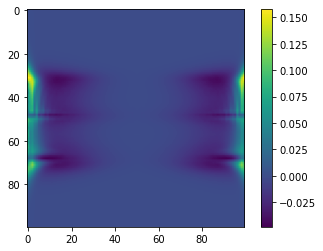

In [228]:
plt.imshow(error_map_4-error_map)
plt.colorbar()

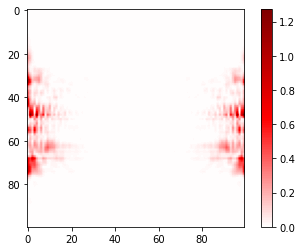

In [229]:
plt.imshow(Anomalies_spectra_4[0],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

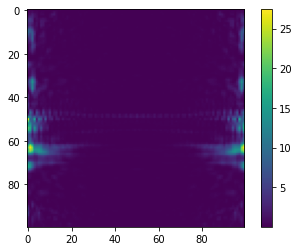

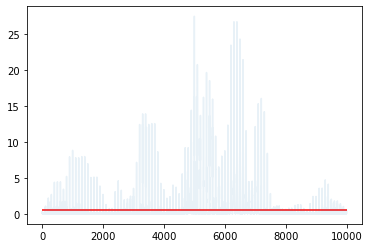

In [231]:
i=7
plt.imshow(Anomalies_spectra_4[i]/error_map/2)
plt.colorbar()
plt.show()
plt.plot((Anomalies_spectra_4[i]/error_map/2).ravel(),alpha=0.1)
plt.hlines((Anomalies_spectra_4[i]/error_map/2).mean(),0,10000,color='r')
plt.show()

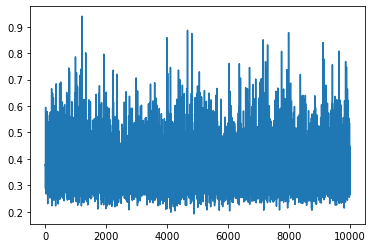

In [232]:
plt.plot((Anomalies_spectra_4/error_map/2).mean(axis=(1,2)))

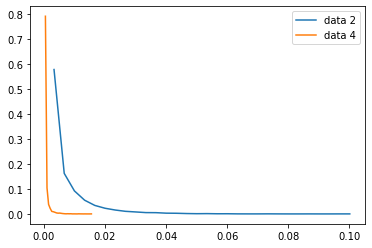

In [236]:
i=50
j=50

data,x=np.histogram(Anomalies_spectra[:,i,j],bins=30)

norm_data=data/data.sum()
plt.plot(x[1:],norm_data,label='data 2')

data,x=np.histogram(Anomalies_spectra_4[:,i,j],bins=30)

norm_data=data/data.sum()
plt.plot(x[1:],norm_data,label='data 4')

plt.legend()

In [247]:
Observed_spec=deepcopy(Anomalies_spectra[-1])

In [258]:
Observed_spec[i,j]

0.0010887642529392747

In [259]:
Anomalies_spectra[:,i,j]

array([5.25654530e-03, 3.22824357e-03, 3.64405916e-03, ...,
       4.61561915e-05, 2.60646582e-03, 1.08876425e-03])

In [260]:
Anomalies_spectra_4[:,i,j]

array([2.92791046e-04, 4.75626406e-05, 9.36283382e-04, ...,
       5.85007758e-04, 5.22480456e-05, 8.10768280e-06])

In [264]:
def probability(Observed_spec,Distribution_to_check,i,j):
    mean=Distribution_to_check[:,i,j].mean()
    #prob=(1/mean)*np.exp(-Observed_spec[i,j]/mean)
    return prob

In [256]:
i=50
j=50
print(probability(Observed_spec,Anomalies_spectra,i,j))
print(probability(Observed_spec,Anomalies_spectra_4,i,j))

151.62670061135344
187.98728047253016


In [261]:
probs_true=np.zeros((100,100))
probs_false=np.zeros((100,100))

for i in range(100):
    for j in range(100):
        probs_true[i,j]=probability(Observed_spec,Anomalies_spectra,i,j)
        probs_false[i,j]=probability(Observed_spec,Anomalies_spectra_4,i,j)

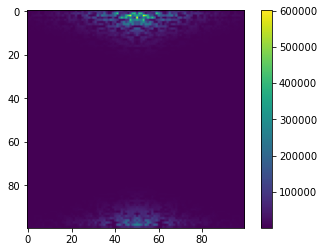

In [262]:
plt.imshow(probs_true)
plt.colorbar()

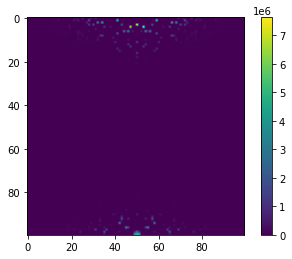

In [263]:
plt.imshow(probs_false)
plt.colorbar()

NameError: name 'kx' is not defined

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_32361/3156966419.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(x[1:],np.log(norm_data))


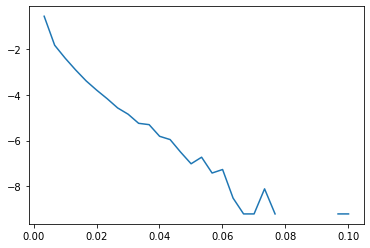

In [178]:
plt.plot(x[1:],np.log(norm_data))

In [266]:
spec2=np.fft.fft(Anomalies_images)
spec4=np.fft.fft(Anomalies_images_4)

In [267]:
spec2.shape

(10000, 100, 100)

In [268]:
Obs_spec=deepcopy(spec2[-1])

In [270]:
errormap_real=spec2.real.std(axis=0)
errormap_imag=spec2.imag.std(axis=0)

In [274]:
np.mean(((Obs_spec.real-spec2.real.mean(axis=0))/errormap_real)**2)

1.0536399498438438

In [276]:
np.nanmean(((Obs_spec.imag-spec2.imag.mean(axis=0))/errormap_imag)**2)

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_32361/4111139175.py:1: RuntimeWarning: invalid value encountered in true_divide
  np.nanmean(((Obs_spec.imag-spec2.imag.mean(axis=0))/errormap_imag)**2)


0.9939012297286649

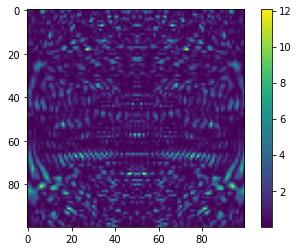

In [287]:
plt.imshow(((spec4[-1].real-spec4.real.mean(axis=0))/spec4.real.std(axis=0))**2)
plt.colorbar()

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_32361/863960948.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(((spec4[-1].imag-spec4.imag.mean(axis=0))/spec4.imag.std(axis=0))**2)


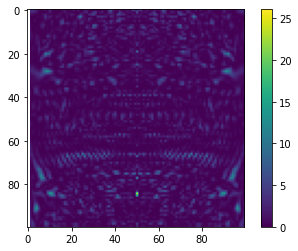

In [288]:
plt.imshow(((spec4[-1].imag-spec4.imag.mean(axis=0))/spec4.imag.std(axis=0))**2)
plt.colorbar()

1.0271885643044372


/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_32361/1996464958.py:1: RuntimeWarning: invalid value encountered in true_divide
  q=((spec4[15].imag-spec4.imag.mean(axis=0))/spec4.imag.std(axis=0))**2


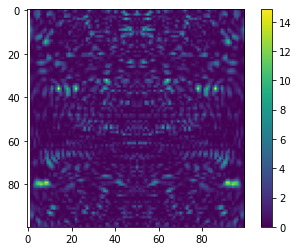

In [297]:
q=((spec4[15].imag-spec4.imag.mean(axis=0))/spec4.imag.std(axis=0))**2
plt.imshow(q)
plt.colorbar()
print(np.nanmean(q))

14.36017358703652


/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_32361/3620161951.py:1: RuntimeWarning: invalid value encountered in true_divide
  q=((spec2[-1].imag-spec4.imag.mean(axis=0))/spec4.imag.std(axis=0))**2


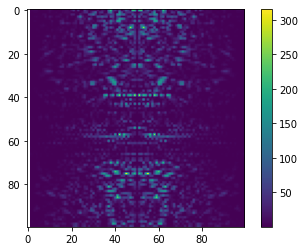

In [292]:
q=((spec2[-1].imag-spec4.imag.mean(axis=0))/spec4.imag.std(axis=0))**2
plt.imshow(q)
plt.colorbar()
print(np.nanmean(q))

In [172]:
(x/2/popt[2]).mean()

13.277345955942158

In [173]:
popt[2]

array([0.00188521])

In [175]:
x.mean()/2

0.02503053419309189

In [149]:
params

(1.3119756314175364, -2.1019582309778237e-32, 0.07432620786432982)

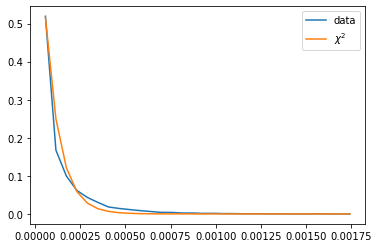

In [143]:
i=0
j=0

q=spectra[:,i,j]
#p=(q.real/q.real.std())**2+(q.imag/q.imag.std())**2
data,x=np.histogram(np.abs(q)**2,bins=30)

norm_data=data/data.sum()

distribution = "chi2"
distr = getattr(sc.stats, distribution)
params = distr.fit(norm_data)

l=sc.stats.chi2.pdf(x[1:],df=2,loc=0,scale=0.00004)

plt.plot(x[1:],norm_data,label='data')
plt.plot(x[1:],l/l.sum(),label=r'$\chi^2$')
plt.legend()



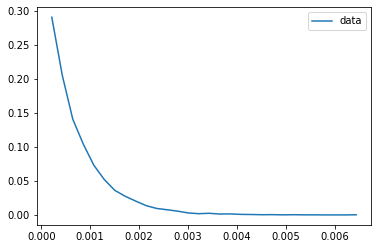

In [154]:
i=20
j=30

q=spectra[:,i,j]
#p=(q.real/q.real.std())**2+(q.imag/q.imag.std())**2
data,x=np.histogram(np.abs(q)**2,bins=30)

norm_data=data/data.sum()

distribution = "chi2"
distr = getattr(sc.stats, distribution)
params = distr.fit(norm_data)

l=sc.stats.chi2.pdf(x[1:],df=2,loc=0,scale=0.00004)

plt.plot(x[1:],norm_data,label='data')
#plt.plot(x[1:],l/l.sum(),label=r'$\chi^2$')
plt.legend()




In [79]:
popt

(9.105840823585789,
 1.8976823373868856,
 2.2378882670602764,
 0.08035372351346688)

0.189789132638484

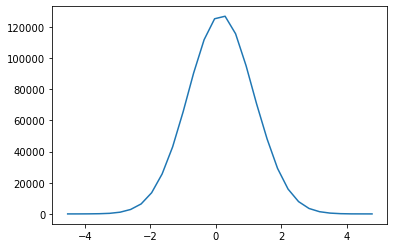

In [417]:
q=np.random.normal(size=1000000)
data,x=np.histogram(q,bins=30)
plt.plot(x[1:],data)
sc.stats.ttest_1samp(q,0,alternative='two-sided')[1]

In [418]:
p=np.fft.fft(q)

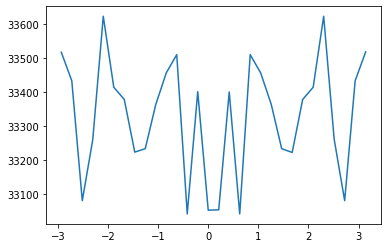

In [422]:
data,x=np.histogram(np.angle(p),bins=30)
plt.plot(x[1:],data)

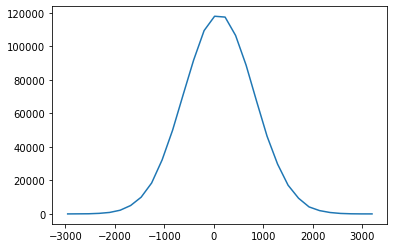

In [424]:
data,x=np.histogram(p.real,bins=30)
plt.plot(x[1:],data)

In [429]:
(np.abs(p)**2).sum()/(1000000**2)

0.9993403190039816

In [ ]:
q=np.random.normal(size=(10000,100,100))

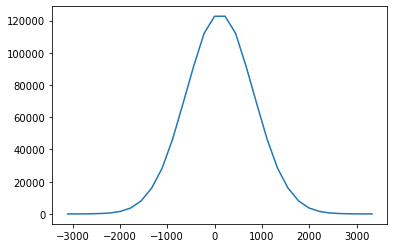

In [425]:
data,x=np.histogram(p.imag,bins=30)
plt.plot(x[1:],data)

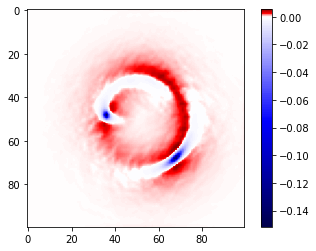

In [17]:
plt.imshow(Anomalies_images.mean(axis=0),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

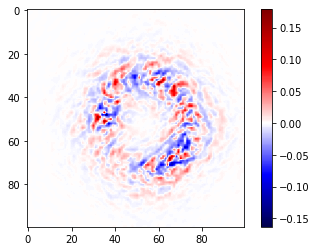

In [392]:
plt.imshow(Anomalies_images[4],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

In [328]:
np.fft.fft2(Anomalies_images,axis=[1,2])

TypeError: _fftn_dispatcher() got an unexpected keyword argument 'axis'

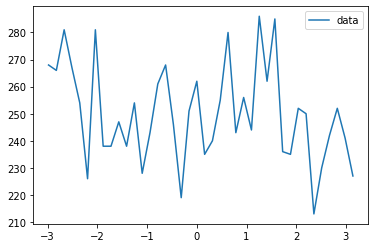

In [393]:
i=0
j=10
Distribution=np.angle(np.fft.fft(Anomalies_images))[:,i,j]
bins=40

data,x=np.histogram(Distribution,bins=bins)

distribution = "chi2"
distr = getattr(sc.stats, distribution)
params = distr.fit(data)

#popt=fit_likelihood(x[1:],data,distr_func='chi2',multiplier=1,Poisson_errs=False)

#plt.plot(x[1:],data)
#plt.plot(x[1:],sc.stats.chi2.pdf(x[1:],df=popt[0],loc=popt[1],scale=popt[2]),label=r'$\chi^2$')
plt.plot(x[1:],data,label='data')


plt.legend()

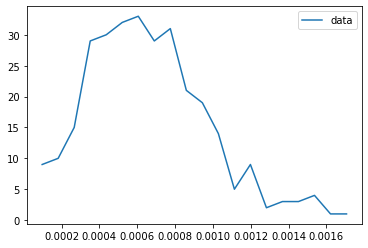

In [365]:
i=0
j=30
Distribution=np.abs(np.fft.fft(Anomalies_images)[:,i,j])
bins=20

data,x=np.histogram(Distribution,bins=bins)

distribution = "chi2"
distr = getattr(sc.stats, distribution)
params = distr.fit(data)

#popt=fit_likelihood(x[1:],data,distr_func='chi2',multiplier=1,Poisson_errs=False)

#plt.plot(x[1:],data)
#plt.plot(x[1:],sc.stats.chi2.pdf(x[1:],df=popt[0],loc=popt[1],scale=popt[2]),label=r'$\chi^2$')
plt.plot(x[1:],data,label='data')


plt.legend()

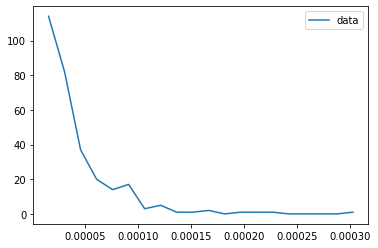

In [360]:
i=20
j=30
Distribution=np.abs(np.fft.fft(Anomalies_images))[:,i,j]**2
bins=20

data,x=np.histogram(Distribution,bins=bins)

distribution = "chi2"
distr = getattr(sc.stats, distribution)
params = distr.fit(data)

#popt=fit_likelihood(x[1:],data,distr_func='chi2',multiplier=1,Poisson_errs=False)

#plt.plot(x[1:],data)
#plt.plot(x[1:],sc.stats.chi2.pdf(x[1:],df=popt[0],loc=popt[1],scale=popt[2]),label=r'$\chi^2$')
plt.plot(x[1:],data,label='data')


plt.legend()

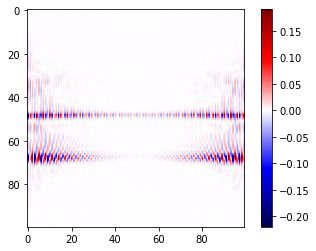

In [349]:
plt.imshow(np.fft.fft(Anomalies_images).real.mean(axis=0),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

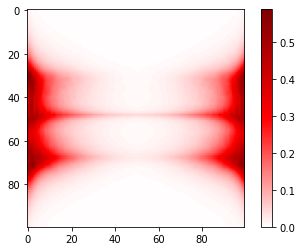

In [350]:
plt.imshow(np.abs(np.fft.fft(Anomalies_images)).mean(axis=0),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

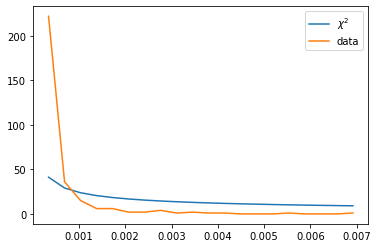

In [325]:
i=50
j=50
Distribution=Anomalies_spectra[:,i,j]
bins=20

data,x=np.histogram(Distribution,bins=bins)

distribution = "chi2"
distr = getattr(sc.stats, distribution)
params = distr.fit(data)

popt=fit_likelihood(x[1:],data,distr_func='nc_chi2',multiplier=1,Poisson_errs=False)

#plt.plot(x[1:],data)
plt.plot(x[1:],sc.stats.ncx2.pdf(x[1:],df=popt[0],nc=popt[1],loc=0,scale=popt[3]),label=r'$\chi^2$')
plt.plot(x[1:],data,label='data')


plt.legend()

In [300]:
popt

(0.030408879340320702, 9.265768922765639e-07, 0, 0.8750091403567829)

In [297]:
popt

(1, 0.00010857204448502575, 1.393244322371707)

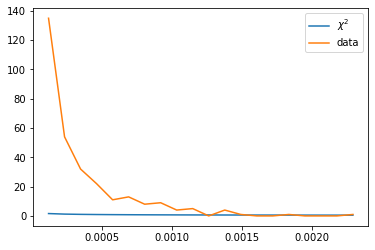

In [352]:
i=0
j=0
Distribution=Anomalies_spectra[:,i,j]
bins=20

data,x=np.histogram(Distribution,bins=bins)

distribution = "chi2"
distr = getattr(sc.stats, distribution)
params = distr.fit(data)
arg = params[:-2]
loc=params[-2]
scale=params[-1]


#popt=fit_likelihood(x[1:],data,distr_func='chi2',multiplier=1,Poisson_errs=False)

#plt.plot(x[1:],data)
plt.plot(x[1:],sc.stats.chi2.pdf(x[1:],*arg, loc=loc, scale=scale),label=r'$\chi^2$')
plt.plot(x[1:],data,label='data')


plt.legend()

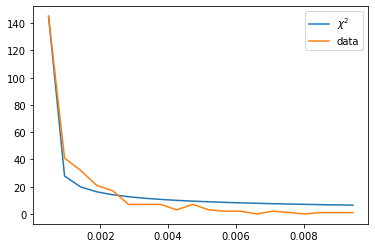

In [259]:
i=0
j=50
Distribution=Anomalies_spectra[:,i,j]
bins=20

data,x=np.histogram(Distribution,bins=bins)

distribution = "chi2"
distr = getattr(sc.stats, distribution)
params = distr.fit(data)

popt=fit_likelihood(x[1:],data,distr_func='chi2',multiplier=1,Poisson_errs=False)

#plt.plot(x[1:],data)
plt.plot(x[1:],sc.stats.chi2.pdf(x[1:],df=popt[0],loc=popt[1],scale=popt[2]),label=r'$\chi^2$')
plt.plot(x[1:],data,label='data')


plt.legend()

In [210]:
popt

(1, 2.714713049299393e-06, 25.419636145900736)

In [172]:
popt

(1, array([0.02136336]))

In [ ]:
sc.stats.

56


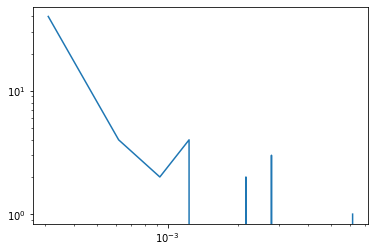

In [121]:
i=10

k_values=np.arange(0,np.abs(np.fft.fftfreq(100,0.08)).max(),0.125)
mask=(k_grid>=k_values[i-1])&(k_grid<k_values[i])
print(mask.sum())
data,x=np.histogram(Anomalies_spectra[0][mask],bins=20)
plt.loglog(x[1:],data)

In [120]:
Anomalies_spectra[0][mask]

array([1.22212633e-05, 1.22212633e-05, 8.50274544e-06, 8.50274544e-06,
       1.24086830e-05, 1.24086830e-05, 8.19072866e-06, 8.19072866e-06,
       8.08559284e-06, 8.08559284e-06, 6.62282732e-06, 6.62282732e-06,
       4.24900295e-05, 4.24900295e-05, 1.04047776e-04, 4.07384727e-05,
       4.07384727e-05, 1.04047776e-04, 1.47229557e-04, 1.47229557e-04,
       2.57602885e-03, 1.13878321e-03, 2.22112641e-04, 2.45200779e-04,
       5.28880044e-04, 5.28880044e-04, 2.45200779e-04, 2.22112641e-04,
       1.13878321e-03, 6.17987508e-03, 2.72426306e-03, 2.01431790e-03,
       9.68941748e-04, 8.87200481e-04, 8.87200481e-04, 9.68941748e-04,
       2.01431790e-03, 2.72426306e-03, 3.61468052e-04, 3.61468052e-04,
       1.79331831e-04, 2.88001789e-07, 2.88001789e-07, 1.79331831e-04,
       2.50823124e-04, 2.50823124e-04, 1.19980130e-04, 1.19980130e-04,
       1.25471298e-05, 1.25471298e-05, 4.51251514e-05, 4.51251514e-05,
       5.57720601e-05, 5.57720601e-05, 4.27726773e-05, 4.27726773e-05])

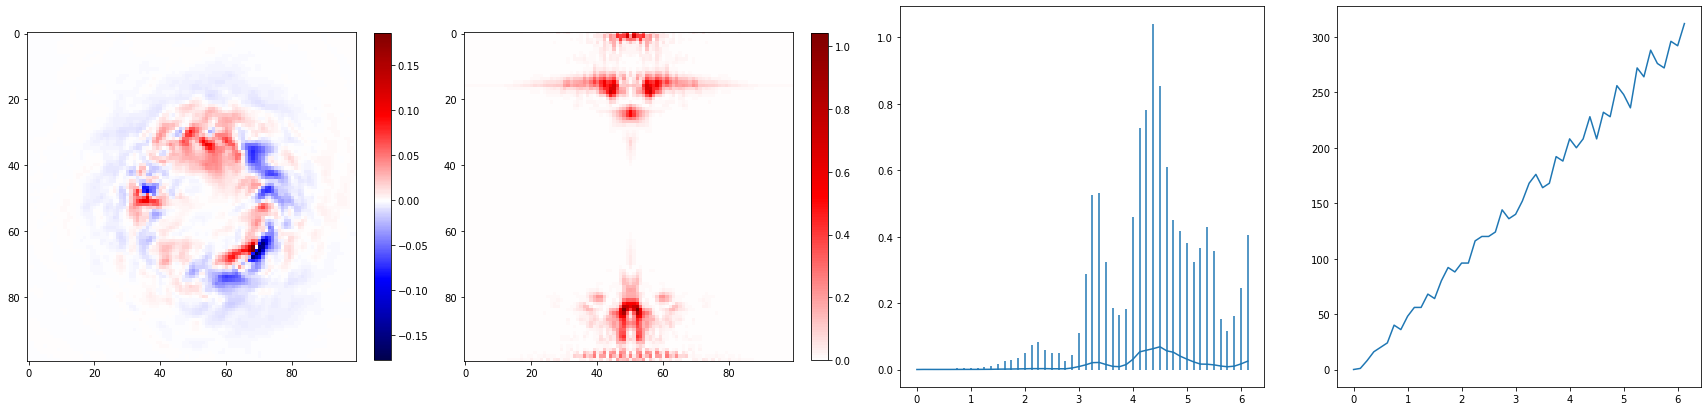

In [91]:
i=0
for i in range(1):
    fig,ax=plt.subplots(1,4,figsize=(30,7))
    img=ax[0].imshow(Anomalies_images[i],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    fig.colorbar(img,ax=ax[0],fraction=0.045)
    img=ax[1].imshow(np.fft.fftshift(Anomalies_spectra[i]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    fig.colorbar(img,ax=ax[1],fraction=0.045)
    k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(Anomalies_spectra[i],k_grid)
    ax[2].errorbar(k_values,radial_spectrum,radial_errorbars)
    ax[3].plot(k_values,counts)
    plt.show()

array([2.33939821e-04, 3.56005950e-04, 2.00276442e-04, 1.71025350e-05,
       2.41804301e-04, 3.84491993e-05, 1.14134614e-04, 1.32312406e-05,
       3.93455002e-04, 7.32823961e-04, 1.41768190e-05, 1.14105304e-04,
       5.54109653e-05, 3.95373620e-05, 7.05778103e-05, 2.90922472e-04,
       5.74074420e-07, 1.42859588e-03, 2.25216445e-04, 2.62898738e-04,
       2.93683995e-05, 1.23956896e-05, 1.06036087e-03, 4.16944848e-04,
       1.15609967e-04, 1.09082296e-04, 1.12739761e-04, 3.24417856e-04,
       1.48559910e-04, 8.22734919e-04, 4.34005127e-04, 9.66307464e-04,
       2.99030141e-04, 1.50626707e-06, 1.31601605e-04, 6.18711801e-04,
       2.95961995e-06, 3.59470932e-04, 1.41898284e-04, 2.51670555e-04,
       1.99533095e-04, 2.42093552e-04, 4.90651798e-04, 1.48226994e-05,
       3.60243258e-04, 1.23264038e-04, 9.49500784e-04, 2.27877742e-05,
       9.01800509e-04, 1.02919834e-05, 1.53546162e-04, 6.34457720e-06,
       7.09493556e-05, 4.59713286e-04, 4.10554681e-05, 3.51753992e-04,
      

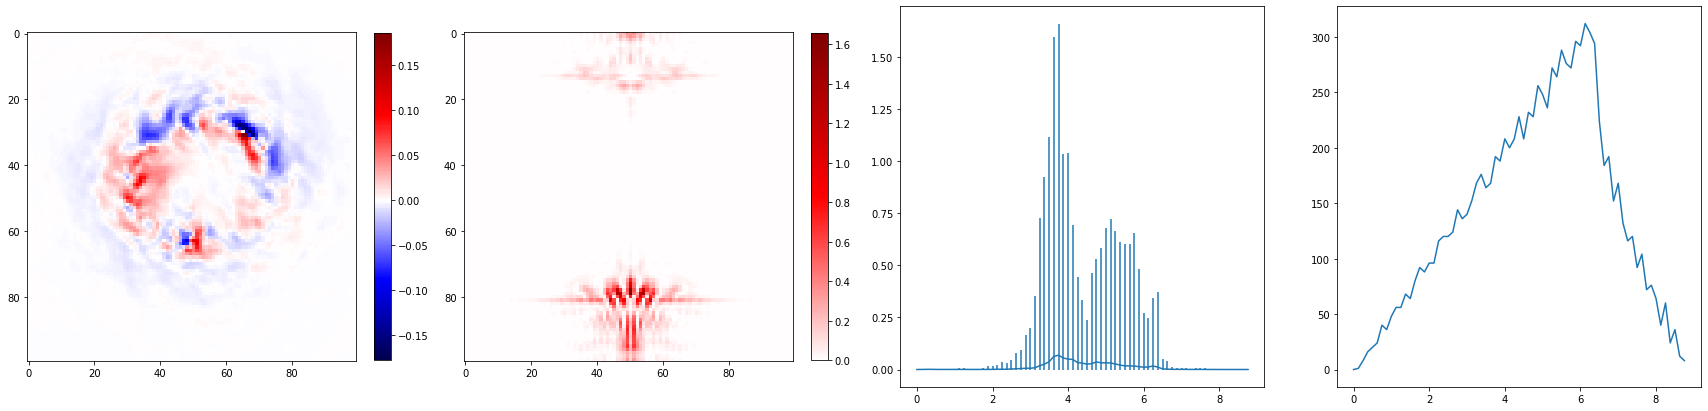

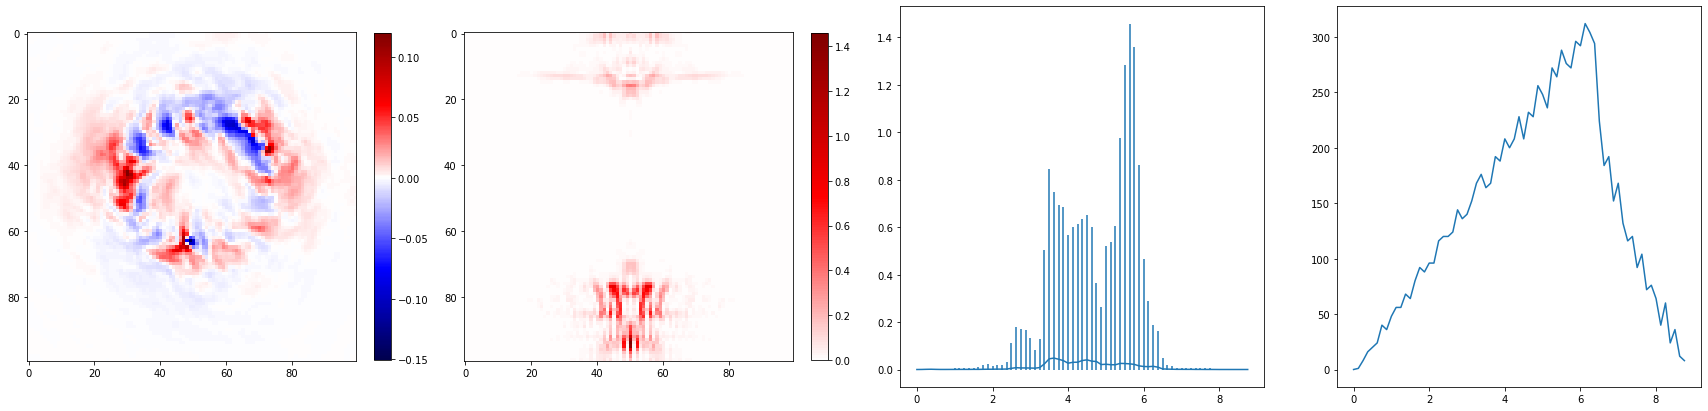

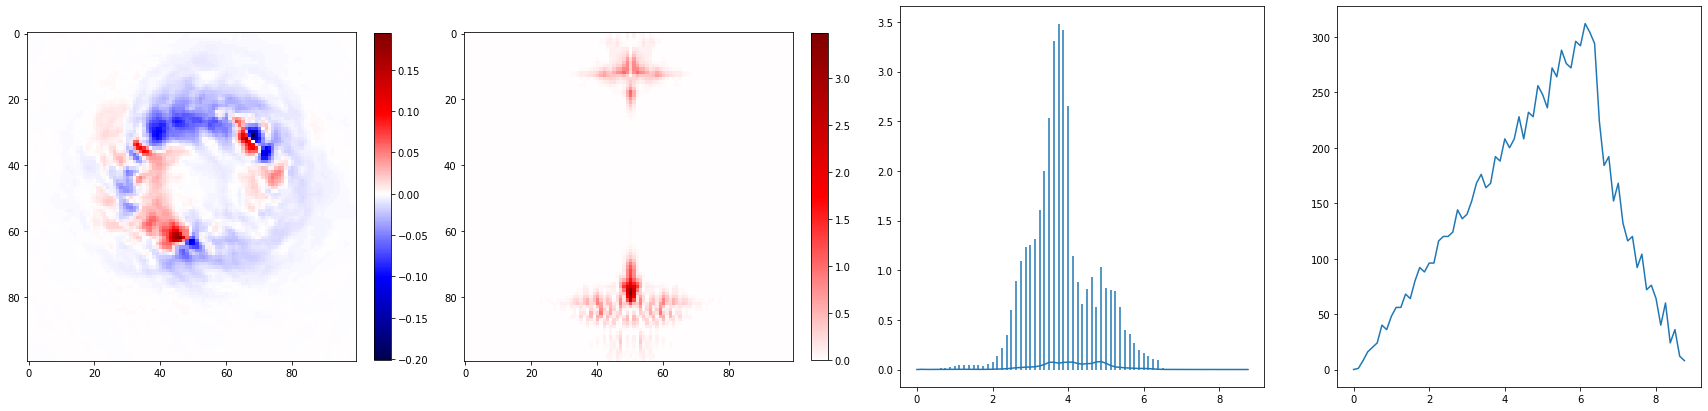

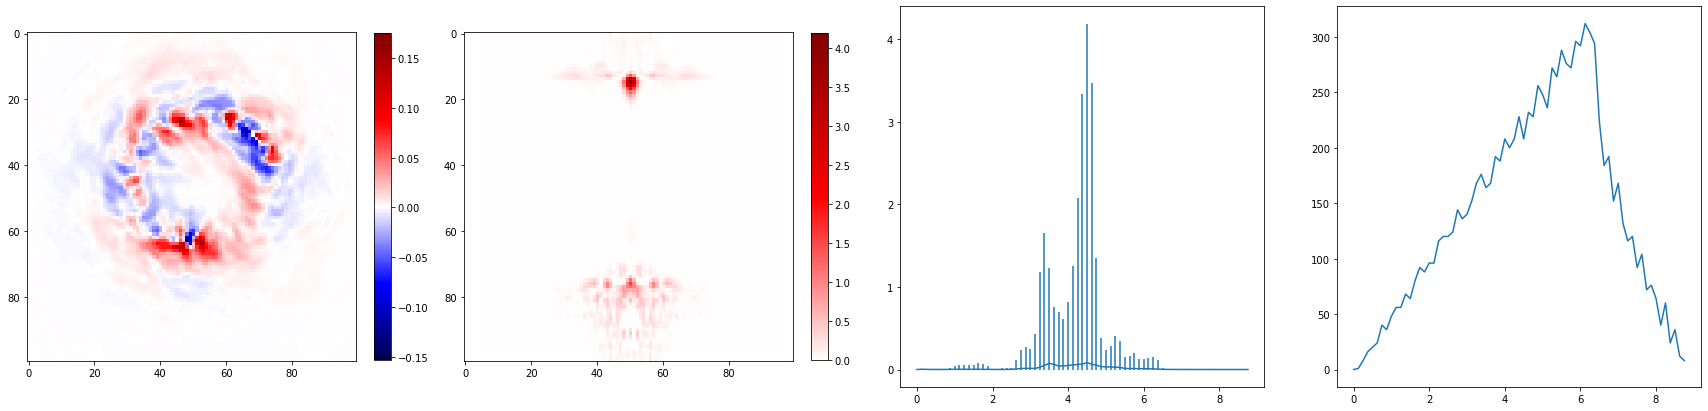

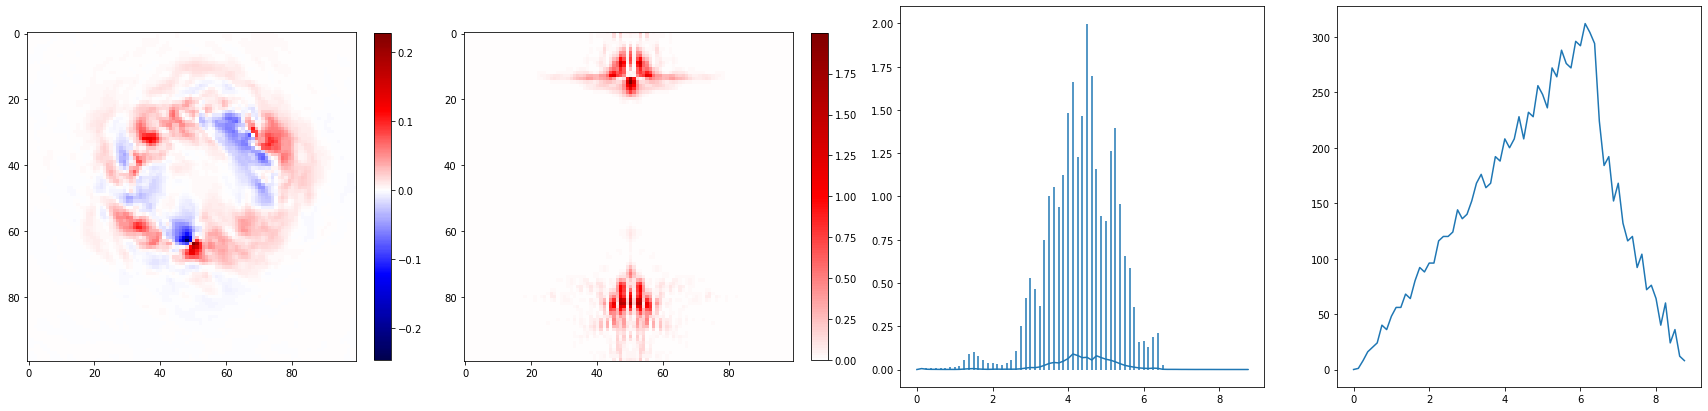

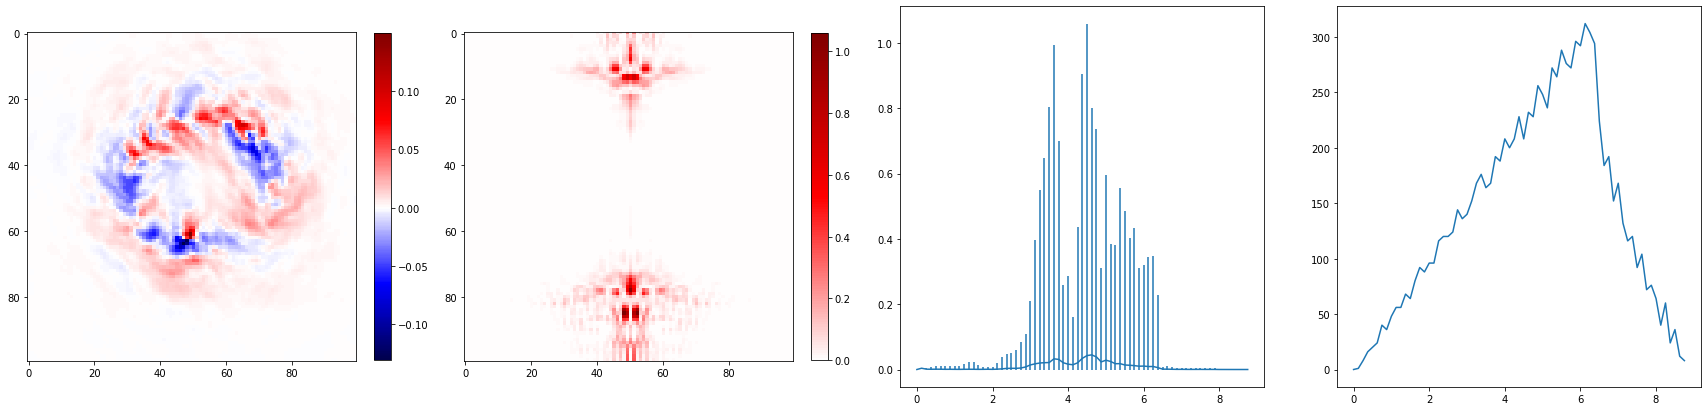

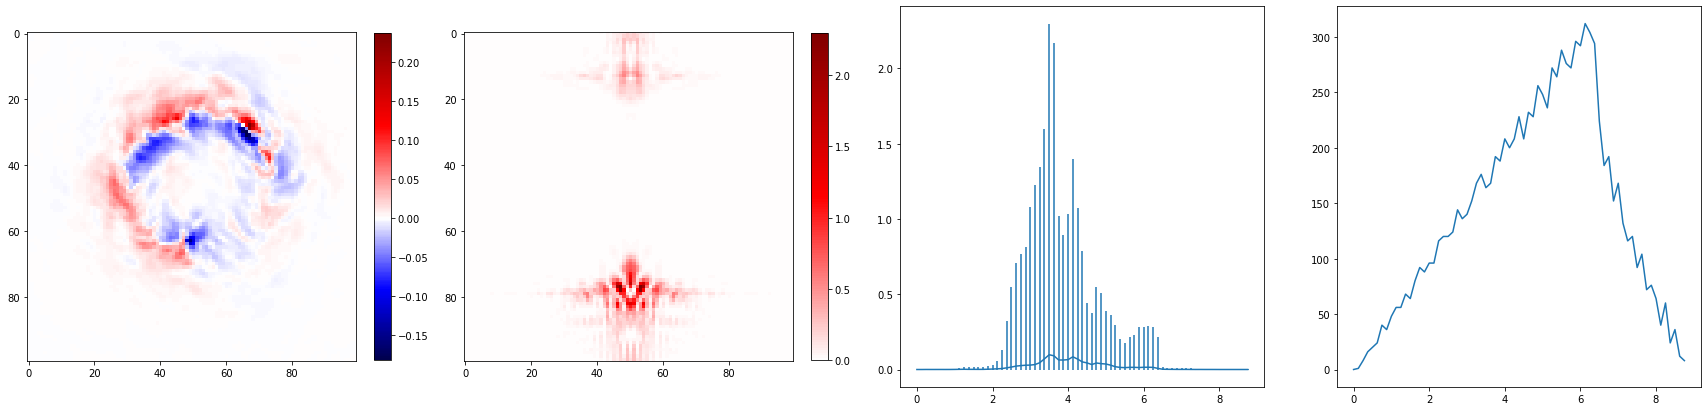

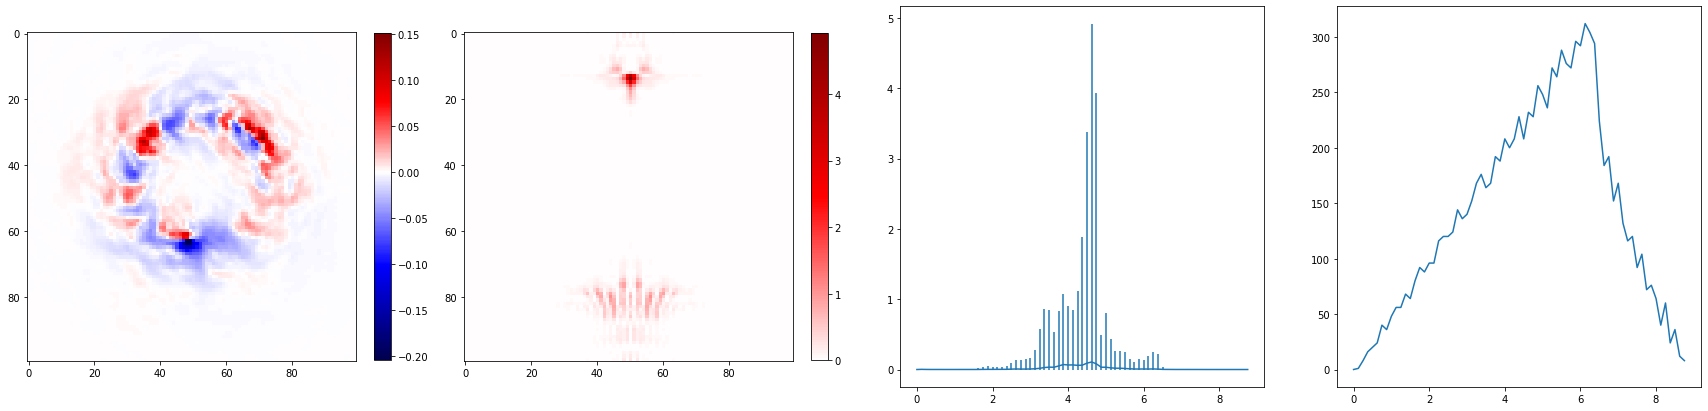

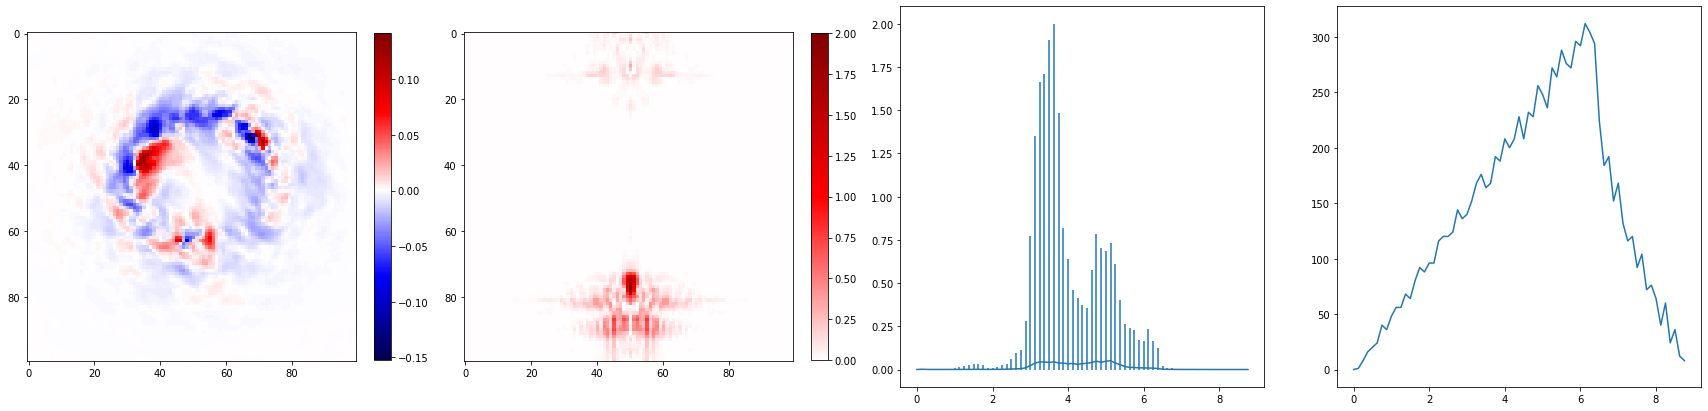

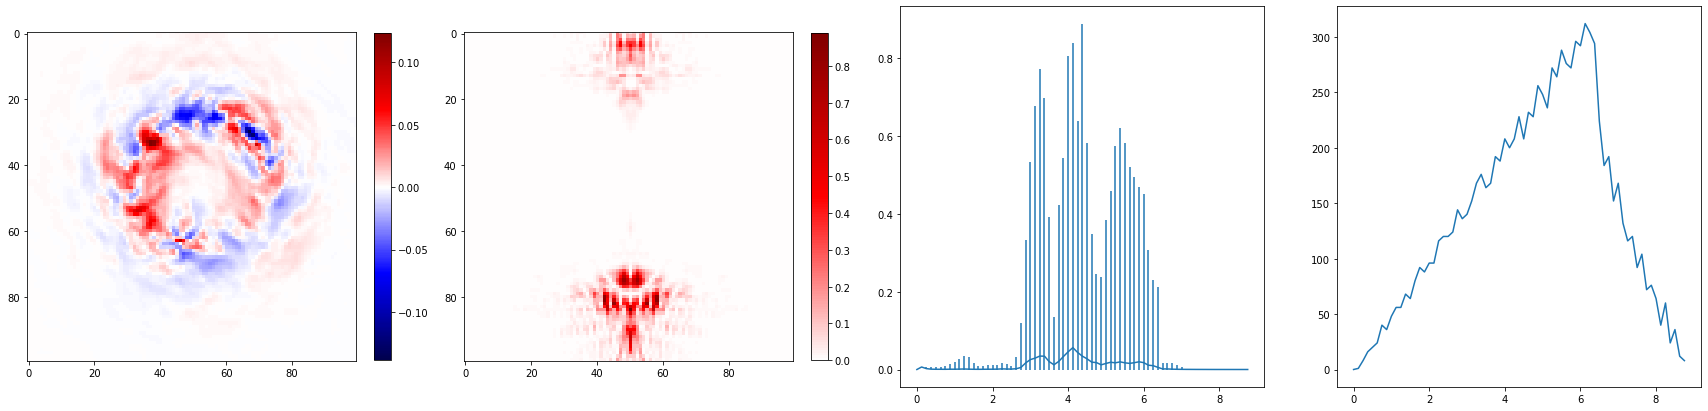

In [83]:
i=0
for i in range(10):
    fig,ax=plt.subplots(1,4,figsize=(30,7))
    image=np.rot90(Anomalies_images[i])
    spec=np.abs(np.fft.fft(image))**2
    img=ax[0].imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    fig.colorbar(img,ax=ax[0],fraction=0.045)
    img=ax[1].imshow(np.fft.fftshift(spec),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    fig.colorbar(img,ax=ax[1],fraction=0.045)
    k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(spec,k_grid)
    ax[2].errorbar(k_values,radial_spectrum,radial_errorbars)
    ax[3].plot(k_values,counts)
    plt.show()

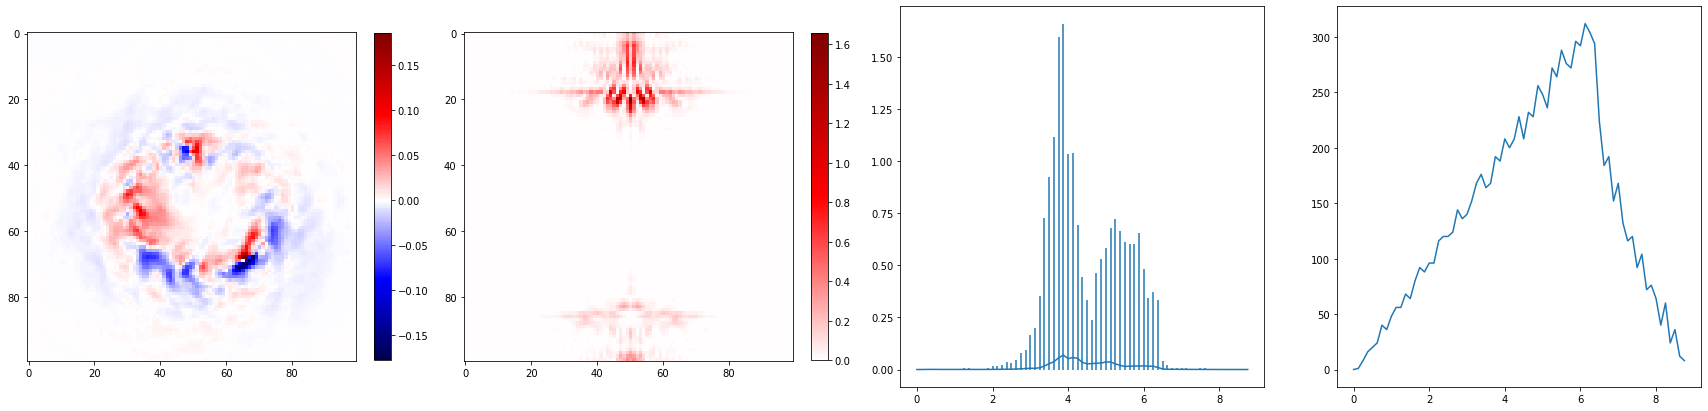

In [76]:
i=0
for i in range(1):
    fig,ax=plt.subplots(1,4,figsize=(30,7))
    image=np.rot90(Anomalies_images[i])[::-1]
    spec=np.abs(np.fft.fft(image))**2
    img=ax[0].imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    fig.colorbar(img,ax=ax[0],fraction=0.045)
    img=ax[1].imshow(np.fft.fftshift(spec),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
    fig.colorbar(img,ax=ax[1],fraction=0.045)
    k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(spec,k_grid)
    ax[2].errorbar(k_values,radial_spectrum,radial_errorbars)
    ax[3].plot(k_values,counts)
    plt.show()

In [33]:
q=np.unique(k_grid)[-1]

In [34]:
np.fft.fftfreq(100,0.08)

array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
        2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
        3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
        4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
        5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,  5.75 ,  5.875,
        6.   ,  6.125, -6.25 , -6.125, -6.   , -5.875, -5.75 , -5.625,
       -5.5  , -5.375, -5.25 , -5.125, -5.   , -4.875, -4.75 , -4.625,
       -4.5  , -4.375, -4.25 , -4.125, -4.   , -3.875, -3.75 , -3.625,
       -3.5  , -3.375, -3.25 , -3.125, -3.   , -2.875, -2.75 , -2.625,
       -2.5  , -2.375, -2.25 , -2.125, -2.   , -1.875, -1.75 , -1.625,
       -1.5  , -1.375, -1.25 , -1.125, -1.   , -0.875, -0.75 , -0.625,
       -0.5  , -0.375, -0.25 , -0.125])

In [39]:
q

8.838834764831844

In [42]:
k_values=np.arange(0,q,0.125)

In [44]:
i=5
().sum()

24

In [25]:
np.unique(k_grid)[500]

4.978076937934969

In [32]:
np.unique(k_grid)

array([0.        , 0.125     , 0.1767767 , ..., 8.66386173, 8.75089281,
       8.83883476])

In [26]:
mask=k_grid==4.978076937934969

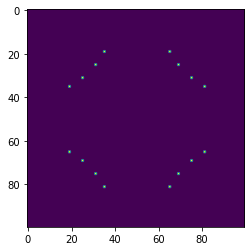

In [27]:
plt.imshow(mask)

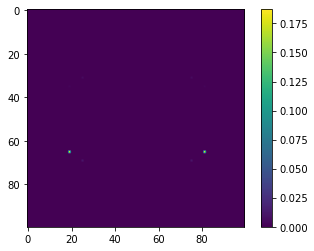

In [30]:
plt.imshow(Anomalies_spectra[0]*mask)
plt.colorbar()

In [31]:
Anomalies_spectra[0][mask]

array([2.06949608e-05, 2.06949608e-05, 6.54321846e-05, 6.54321846e-05,
       5.24093728e-03, 5.24093728e-03, 2.76522917e-03, 2.76522917e-03,
       1.87086634e-01, 1.87086634e-01, 1.04548477e-02, 1.04548477e-02,
       5.96697112e-04, 5.96697112e-04, 2.14889039e-05, 2.14889039e-05])

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 6050.77it/s]


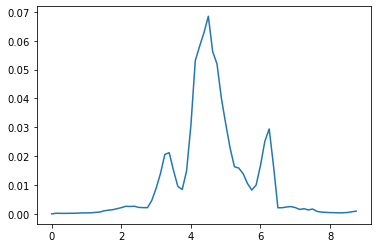

In [49]:
plt.plot(k_values,radial_spectrum)

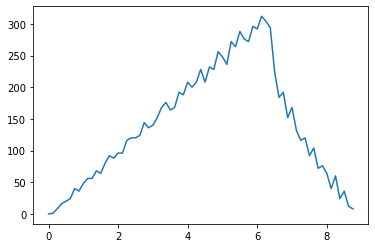

In [50]:
plt.plot(k_values,counts)

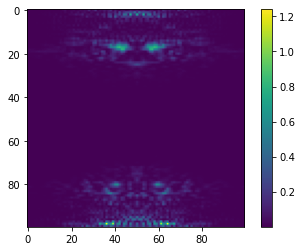

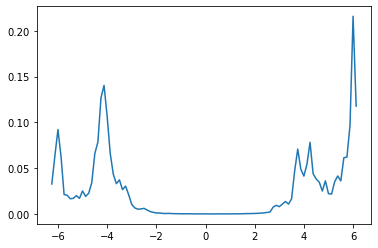

[-7, 2]


In [74]:
p=np.fft.fftshift(Anomalies_spectra[i])
plt.imshow(p)
plt.colorbar()
plt.show()
plt.plot(np.fft.fftshift(np.fft.fftfreq(100,0.08)),p.mean(axis=1))
plt.show()
print([-7,2])

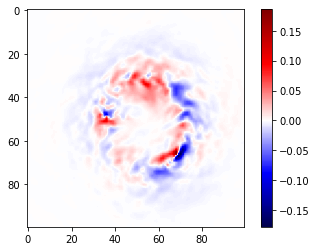

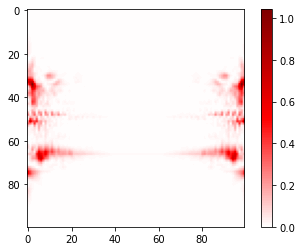

In [77]:
i=0
plt.imshow(Anomalies_images[i],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()
plt.show()
plt.imshow(Anomalies_spectra[i],cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()
plt.show()

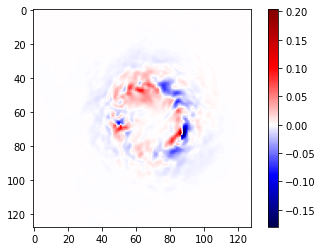

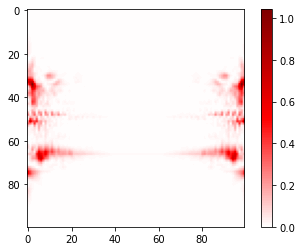

In [87]:
plt.imshow(sc.ndimage.rotate(Anomalies_images[i],20),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()
plt.show()

plt.imshow(np.abs(np.fft.fft(Anomalies_images[i]))**2,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()
plt.show()

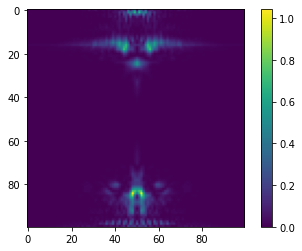

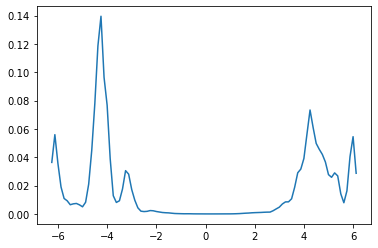

[-7, 4]


In [78]:
p=np.fft.fftshift(Anomalies_spectra[i])
plt.imshow(p)
plt.colorbar()
plt.show()
plt.plot(np.fft.fftshift(np.fft.fftfreq(100,0.08)),p.mean(axis=1))
plt.show()
print([-7,4])

In [37]:
def transform_data(m):
    dpix, dpiy = m.shape
    x_c, y_c = np.unravel_index(np.argmax(m), m.shape)
    angles = np.linspace(0, np.pi*2, min(dpix, dpiy))
    mrc = min(abs(x_c - dpix), abs(y_c - dpiy), x_c, y_c)
    radiuses = np.linspace(0, mrc, max(dpix, dpiy))
    A, R = np.meshgrid(angles, radiuses)
    X = R * np.cos(A)
    Y = R * np.sin(A)
    return A, R, m[X.astype(int) + mrc - 1, Y.astype(int) + mrc - 1]

In [44]:
angles, radiuses, m= transform_data(Anomalies_spectra[i])

In [47]:
radiuses*np.cos(angles)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.14141414,  0.14112943,  0.14027644, ...,  0.14027644,
         0.14112943,  0.14141414],
       [ 0.28282828,  0.28225886,  0.28055288, ...,  0.28055288,
         0.28225886,  0.28282828],
       ...,
       [13.71717172, 13.68955461, 13.6068145 , ..., 13.6068145 ,
        13.68955461, 13.71717172],
       [13.85858586, 13.83068404, 13.74709094, ..., 13.74709094,
        13.83068404, 13.85858586],
       [14.        , 13.97181347, 13.88736738, ..., 13.88736738,
        13.97181347, 14.        ]])

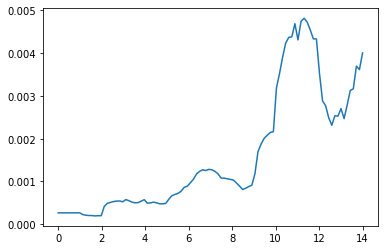

In [45]:
plt.plot(radiuses.mean(axis=1),m.mean(axis=1))

array([0.00140573, 0.00140573, 0.00140573, 0.00140573, 0.00140573,
       0.00140573, 0.00140573, 0.00140573, 0.00140573, 0.00140573,
       0.00140573, 0.00140573, 0.00140573, 0.00140573, 0.00140573,
       0.00140573, 0.00140573, 0.00140573, 0.00140573, 0.00140573,
       0.00140573, 0.00140573, 0.00140573, 0.00140573, 0.00140573,
       0.00140573, 0.00140573, 0.00140573, 0.00140573, 0.00140573,
       0.00140573, 0.00140573, 0.00140573, 0.00140573, 0.00140573,
       0.00140573, 0.00140573, 0.00140573, 0.00140573, 0.00140573,
       0.00140573, 0.00140573, 0.00140573, 0.00140573, 0.00140573,
       0.00140573, 0.00140573, 0.00140573, 0.00140573, 0.00140573,
       0.00141231, 0.00141192, 0.00141347, 0.00141501, 0.0014269 ,
       0.00142005, 0.00140972, 0.0014216 , 0.00141126, 0.00142315,
       0.00143154, 0.00142121, 0.0014247 , 0.00141436, 0.00142275,
       0.00142624, 0.00143464, 0.00141591, 0.0014243 , 0.00142779,
       0.00143619, 0.00140823, 0.00142968, 0.00144623, 0.00144

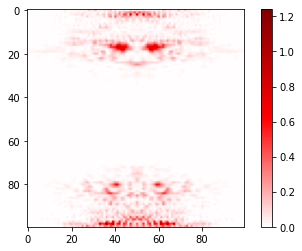

In [10]:
plt.imshow(np.fft.fftshift(Anomalies_spectra[i]),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()
plt.show()

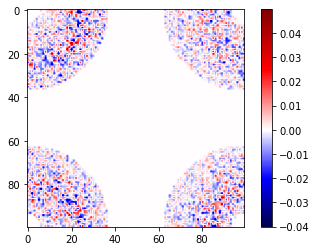

In [38]:
plt.imshow(np.fft.fftshift(masked_q),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

In [91]:
sc.ndimage.rotate(q,45).shape

(199, 199)

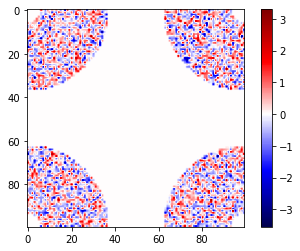

In [77]:
#q=np.random.normal(0,np.sqrt(Image_unperturbed_noiseless/2028))
q=np.random.normal(0,np.ones_like(np.sqrt(Image_unperturbed_noiseless/2028)))
q=sc.ndimage.rotate(q,180)
masked_q=q*Observation_conditions.annulus_mask
plt.imshow(np.fft.fftshift(masked_q),cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
plt.colorbar()

<ErrorbarContainer object of 3 artists>

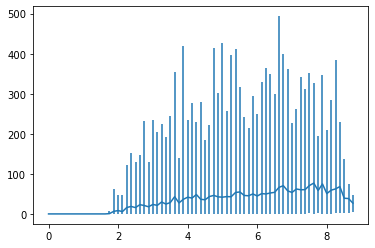

In [82]:
k_values,radial_spectrum,radial_errorbars,counts=map_spec_to_radial(np.abs(np.fft.fft(masked_q))**2,k_grid)
plt.errorbar(k_values,radial_spectrum,radial_errorbars)

<ErrorbarContainer object of 3 artists>

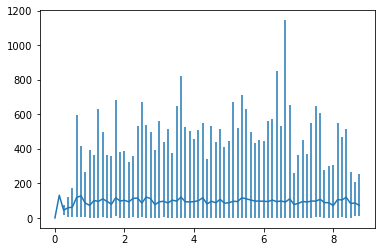

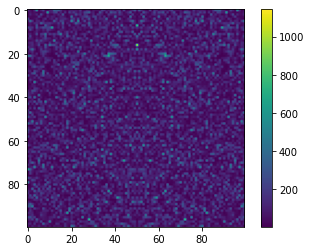

In [79]:
p=np.abs(np.fft.fft(q))**2
plt.imshow(p)
plt.colorbar()

In [126]:
np.fft.fft(masked_q)

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

In [124]:
np.fft.fftshift(np.fft.fft(masked_q))[-2,-2]

(-4.100846427822512-1.2433630871949735j)

array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
        2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
        3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
        4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
        5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,  5.75 ,  5.875,
        6.   ,  6.125, -6.25 , -6.125, -6.   , -5.875, -5.75 , -5.625,
       -5.5  , -5.375, -5.25 , -5.125, -5.   , -4.875, -4.75 , -4.625,
       -4.5  , -4.375, -4.25 , -4.125, -4.   , -3.875, -3.75 , -3.625,
       -3.5  , -3.375, -3.25 , -3.125, -3.   , -2.875, -2.75 , -2.625,
       -2.5  , -2.375, -2.25 , -2.125, -2.   , -1.875, -1.75 , -1.625,
       -1.5  , -1.375, -1.25 , -1.125, -1.   , -0.875, -0.75 , -0.625,
       -0.5  , -0.375, -0.25 , -0.125])

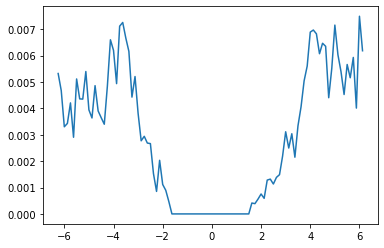

In [64]:
plt.plot(np.fft.fftshift(np.fft.fftfreq(100,0.08)),p.mean(axis=1))

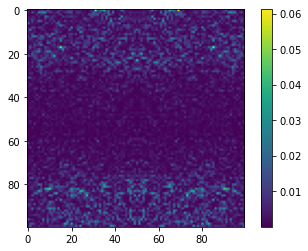

In [25]:
plt.imshow(np.fft.fftshift(Noise_spectra[0]))
plt.colorbar()

In [21]:
spec[0,0]

0.03462791252188935

In [20]:
((np.fft.fft(Noise_images[0]).conj()*np.fft.fft(Noise_images[0])).real>0).all()

True

In [18]:
np.abs(np.fft.fft(Noise_images[0]))**2

array([[1.48057892e-03, 1.67337163e-03, 4.27714449e-04, ...,
        1.17957383e-03, 4.27714449e-04, 1.67337163e-03],
       [9.12061839e-05, 4.92836434e-04, 2.13408749e-03, ...,
        8.45153290e-04, 2.13408749e-03, 4.92836434e-04],
       [4.65805275e-04, 2.19744327e-03, 1.25350688e-03, ...,
        2.09354683e-03, 1.25350688e-03, 2.19744327e-03],
       ...,
       [2.20455457e-03, 1.79460411e-04, 7.20277224e-04, ...,
        4.00066750e-06, 7.20277224e-04, 1.79460411e-04],
       [5.21623150e-05, 8.33837319e-04, 6.11442058e-04, ...,
        7.53743471e-04, 6.11442058e-04, 8.33837319e-04],
       [1.67881662e-06, 4.24692502e-04, 2.53106950e-03, ...,
        2.05526888e-03, 2.53106950e-03, 4.24692502e-04]])

In [205]:
Noise_abs_spec=np.zeros_like(Noise_images)

for i in range(300):
    Noise_abs_spec[i]=np.abs(np.fft.fft(Noise_images[i]))


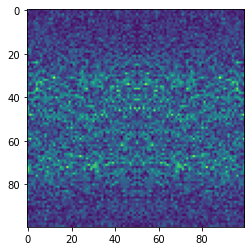

In [207]:
plt.imshow(Noise_abs_spec[1])

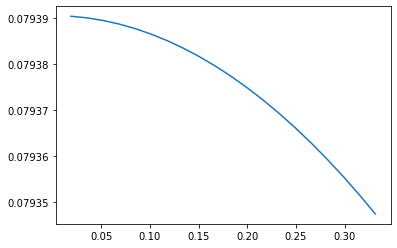

In [242]:
Distribution=Noise_abs_spec[:,0,0]
bins=20

data,x=np.histogram(np.sqrt(Distribution),bins=bins)

distribution = "foldnorm"
distr = getattr(sc.stats, distribution)
params = distr.fit(data)

#plt.plot(x[1:],data)
plt.plot(x[1:],sc.stats.foldnorm.pdf(x[1:],0.1,loc=0,scale=10))

In [243]:
params

(1.1440099398106365, 1.9999999995871096, 10.176006621287794)

In [214]:
x = np.random.normal(loc=0, scale=1, size=100)

distribution = "foldnorm"
distr = getattr(sc.stats, distribution)
params = distr.fit(x)

sc.stats.kstest(x,distribution,args=params)

KstestResult(statistic=0.05996166349644505, pvalue=0.8434246428318437)

In [216]:
params

(1.1440099398106365, 1.9999999995871096, 10.176006621287794)

In [219]:
sc.stats.foldnorm.pdf(x[1:],*params)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [220]:
x[1:]

array([0.01893291, 0.03538435, 0.05183579, 0.06828724, 0.08473868,
       0.10119012, 0.11764157, 0.13409301, 0.15054445, 0.1669959 ,
       0.18344734, 0.19989878, 0.21635022, 0.23280167, 0.24925311,
       0.26570455, 0.282156  , 0.29860744, 0.31505888, 0.33151033])

In [221]:
params

(1.1440099398106365, 1.9999999995871096, 10.176006621287794)

In [228]:
sc.stats.foldnorm.pdf(x[1:],params[0],scale=params[2])

array([0.04075394, 0.04075399, 0.04075408, 0.0407542 , 0.04075435,
       0.04075454, 0.04075476, 0.04075501, 0.04075529, 0.04075561,
       0.04075596, 0.04075634, 0.04075676, 0.04075721, 0.04075769,
       0.0407582 , 0.04075875, 0.04075933, 0.04075994, 0.04076059])

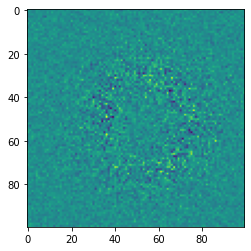

In [84]:
plt.imshow(Noise_images[3])

In [152]:
import scipy
def lognormal(xdata,*params):
    s,loc,scale=params
    #x=(xdata-loc)/scale
    return scipy.stats.lognorm.pdf(x,s,loc=loc,scale=scale)

def lognormal_2par(xdata,*params):
    s,scale=params
    x=(xdata)/scale
    return scipy.stats.lognorm.pdf(x,s)

def normal_distr(xdata,*params):
    mean,sigma=params
    
    return np.exp(-(xdata-mean)**2/2/sigma**2)

def fit_likelihood(xdata,ydata,distr_func='lognormal',multiplier=None,Poisson_errs=False):
    
    #It is a trick to fit distributions in very small numbers here scipy just sets everyrhing to zero
    if multiplier:
        x=multiplier*xdata
    else:
        non_zero_xdata=xdata[np.where(xdata>0)[0]]
        multiplier=1/non_zero_xdata[0]
        x=multiplier*xdata
        
    if distr_func=='lognormal':
        func=lognormal
        init_guess=[1.,0.,1]
    elif distr_func=='normal':
        func=normal_distr
        init_guess=[x.mean(),x.std()]
    elif distr_func=='lognormal2':
        func=lognormal_2par
        init_guess=[1.,1]
    else:
        print('wrong distr_func')
        return None
    
        
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess,sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess)

    
    if distr_func=='lognormal':
        s,loc,scale=popt
        return s,loc/multiplier,scale/multiplier
    if distr_func=='normal':
        amplitude,mean,sigma=popt
        return amplitude,mean/multiplier,sigma/multiplier
    if distr_func=='lognormal2':
        amplitude,s,scale=popt
        return amplitude,s,scale/multiplier

In [157]:
q=np.random.normal(size=1000)
data,x=np.histogram(q,bins=100)
popt=fit_likelihood(x[1:],data,distr_func='normal',Poisson_errs=False)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

In [197]:
x = np.random.normal(loc=0, scale=1, size=100)

distribution = "norm"
distr = getattr(sc.stats, distribution)


params = distr.fit(x)

sc.stats.kstest(x,distribution)

KstestResult(statistic=0.10559794861635152, pvalue=0.2000642772423573)

In [198]:
sc.stats.normaltest(x)

NormaltestResult(statistic=0.8716848311501018, pvalue=0.6467196308470458)

In [189]:
params

(0.0040045700133557426, 1.007510064345209)

In [163]:
params

(-0.07612465717169523, 0.9872366507109147)

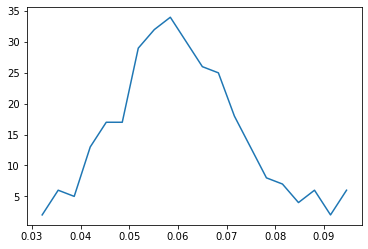

In [200]:
Distribution=clean_Res_Spectra
wavenum_index=0
bins=20

data,x=np.histogram(np.sqrt(Distribution[:,wavenum_index]),bins=bins)
plt.plot(x[1:],data)

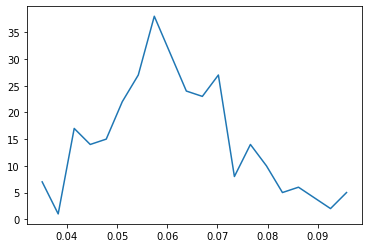

In [201]:
Distribution=Res_Spectra
wavenum_index=0
bins=20

data,x=np.histogram(np.sqrt(Distribution[:,wavenum_index]),bins=bins)
plt.plot(x[1:],data)

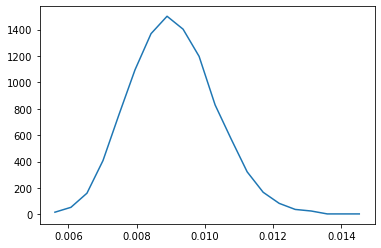

In [202]:
Distribution=Noise_spectra
wavenum_index=0
bins=20

data,x=np.histogram(np.sqrt(Distribution[:,wavenum_index]),bins=bins)
plt.plot(x[1:],data)

In [155]:
data,x=np.histogram(Distribution[:,wavenum_index],bins=bins)
popt=fit_likelihood(x[1:],data,distr_func='lognormal',Poisson_errs=False)
lognorm_distr=lognormal(x[1:],*popt)
plt.plot(x[1:],lognorm_distr,label='LogNormal , p_val={:.2f}'.format(scipy.stats.ks_2samp(data,lognorm_distr)[1]),color='C1')

NameError: name 'Distribution' is not defined

In [153]:
def study_distribution(Distribution,wavenum_index,bins):
    fig=plt.figure(figsize=(15,7))
    data,x=np.histogram(Distribution[:,wavenum_index],bins=bins)
  
    plt.plot(x[1:],data,label='k={:.2f} arcsec'.format(frequencies[wavenum_index]))

    try:
        popt=fit_likelihood(x[1:],data,distr_func='lognormal',Poisson_errs=False)
        lognorm_distr=lognormal(x[1:],*popt)
        plt.plot(x[1:],lognorm_distr,label='LogNormal , p_val={:.2f}'.format(scipy.stats.ks_2samp(data,lognorm_distr)[1]),color='C1')
    except:
        print('LogNormal fit failed') 
        
    try:
        popt=fit_likelihood(x[1:],data,distr_func='lognormal2',Poisson_errs=False)
        lognorm_distr2=lognormal_2par(x[1:],*popt)
        plt.plot(x[1:],lognorm_distr2,label='LogNormal2 , p_val={:.2f}'.format(scipy.stats.ks_2samp(data,lognorm_distr2)[1]),color='C2')
    except:
        print('LogNormal2 fit failed') 

    try:
        popt=fit_likelihood(x[1:],data,distr_func='normal',Poisson_errs=False)
        norm_distr=normal_distr(x[1:],*popt)
        plt.plot(x[1:],norm_distr,label='Normal, p_val={:.2f}'.format(scipy.stats.ks_2samp(data,norm_distr)[1]),color='C3')
    except:
        print('Normal fit failed')

    

    
    
    
    
    plt.legend()
    plt.ylabel('Number density')
    plt.xlabel('Power spectrum')
    plt.show()

LogNormal fit failed
LogNormal2 fit failed
Normal fit failed


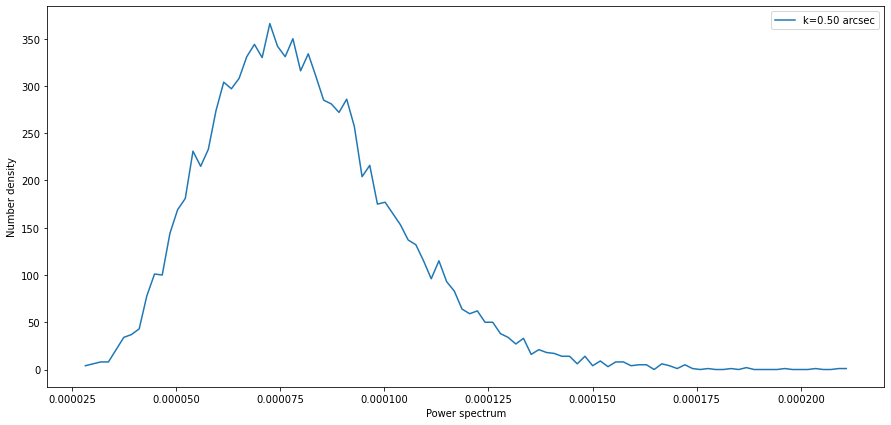

LogNormal fit failed
LogNormal2 fit failed
Normal fit failed


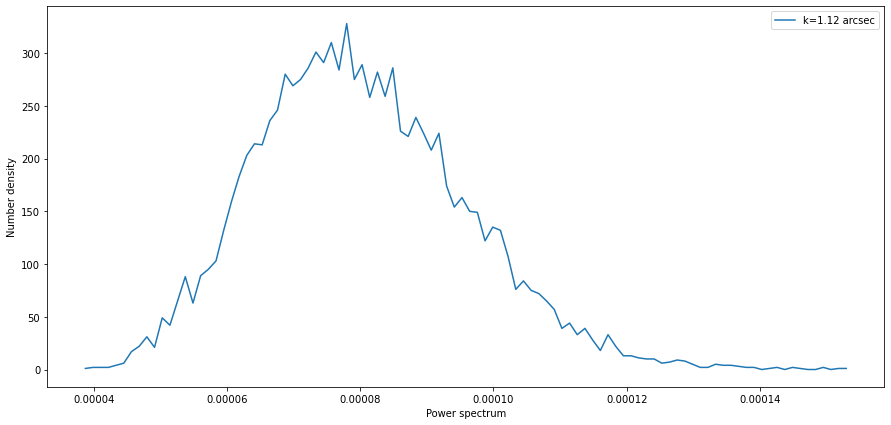

LogNormal fit failed
LogNormal2 fit failed
Normal fit failed


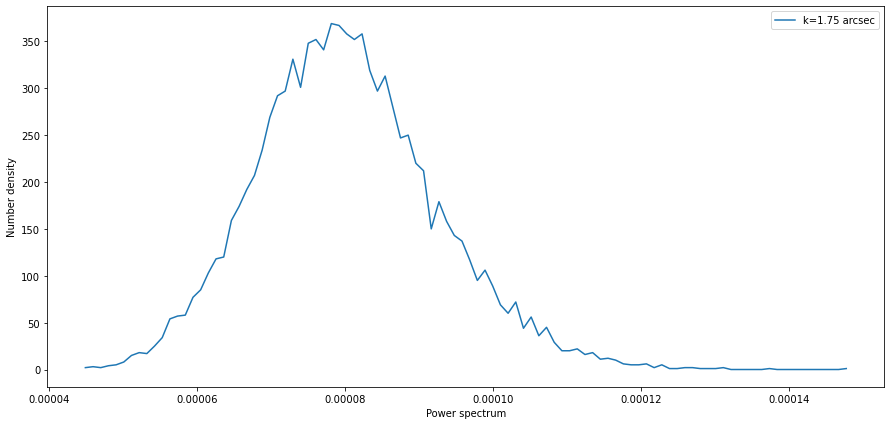

LogNormal fit failed
LogNormal2 fit failed
Normal fit failed


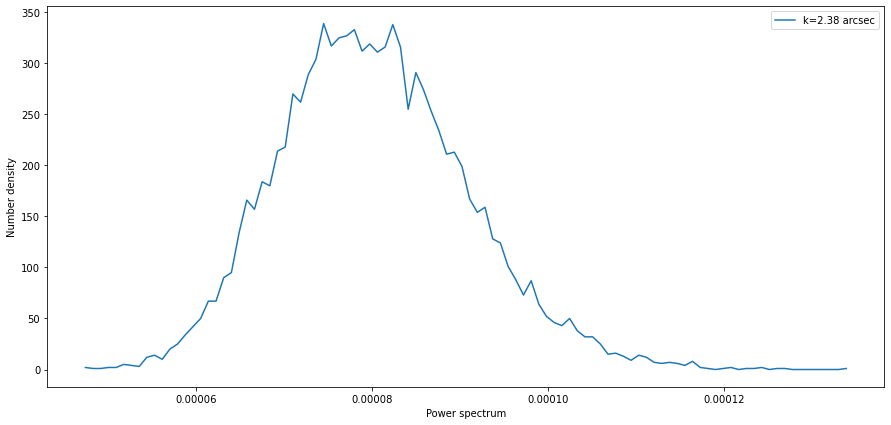

LogNormal fit failed
LogNormal2 fit failed
Normal fit failed


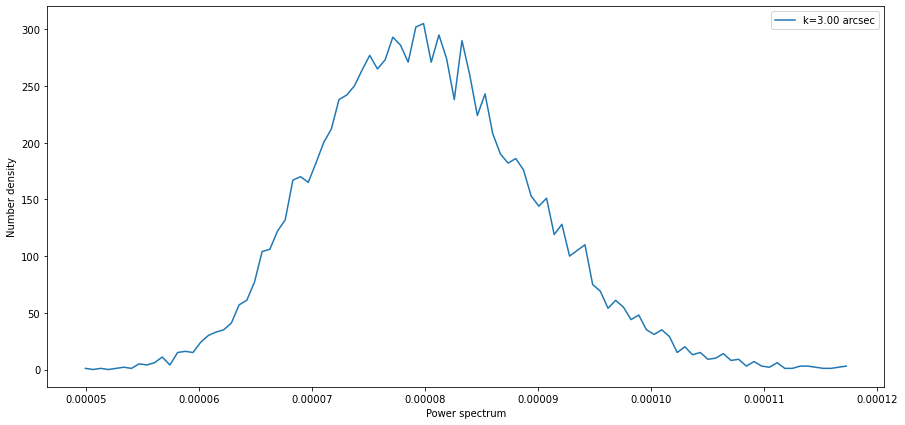

LogNormal fit failed
LogNormal2 fit failed
Normal fit failed


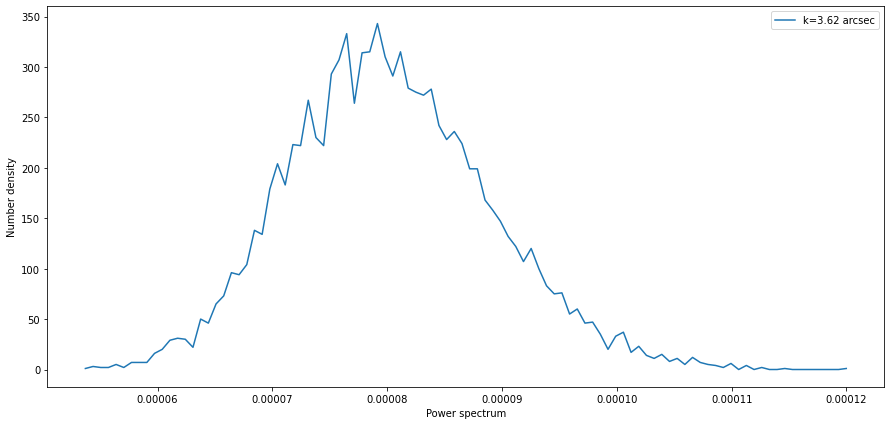

LogNormal fit failed
LogNormal2 fit failed
Normal fit failed


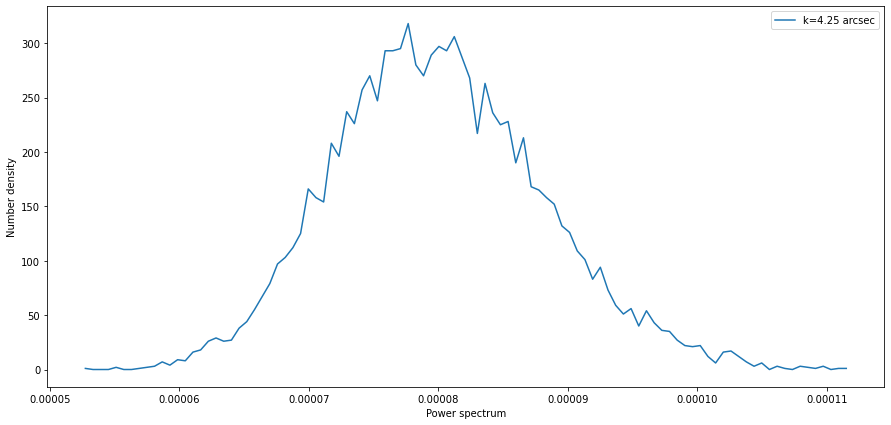

LogNormal fit failed
LogNormal2 fit failed
Normal fit failed


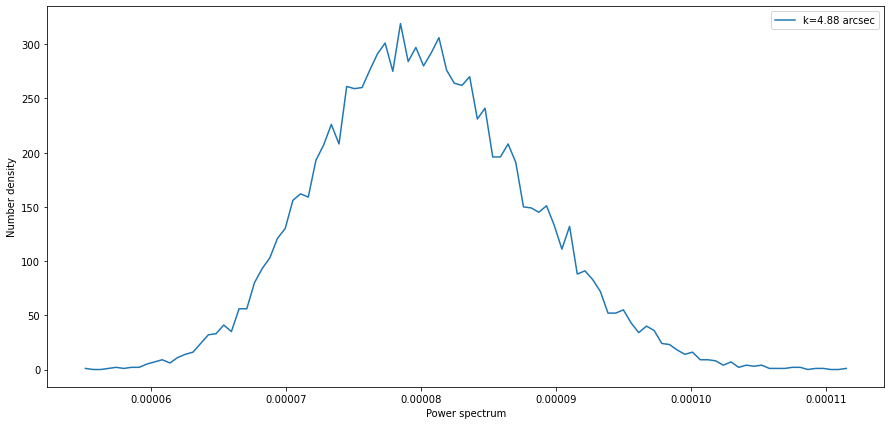

LogNormal fit failed
LogNormal2 fit failed
Normal fit failed


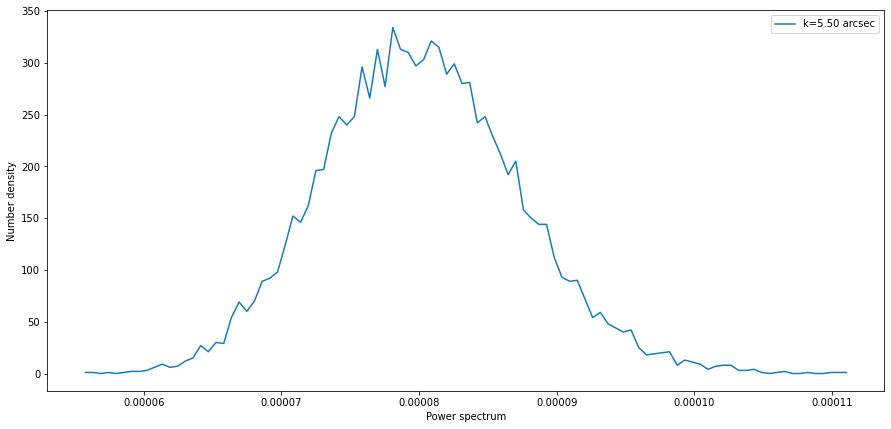

LogNormal fit failed
LogNormal2 fit failed
Normal fit failed


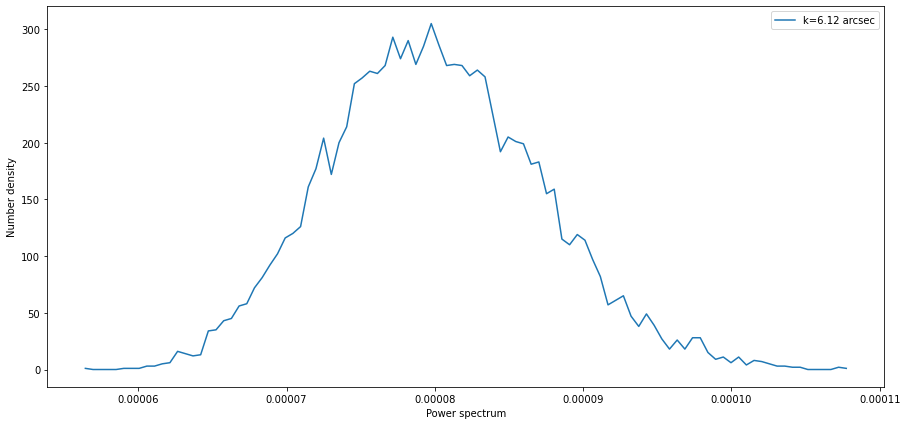

In [154]:
for i in range(0,46,5):
    study_distribution(Noise_spectra,i,100)

In [104]:
import scipy as sc

In [135]:
q=deepcopy(Noise_spectra[:,0])
q-=q.mean()
q/=q.std()
sc.stats.kstest(q,sc.stats.norm(0,1).cdf)

KstestResult(statistic=0.045891098054153256, pvalue=9.708432437718578e-19)

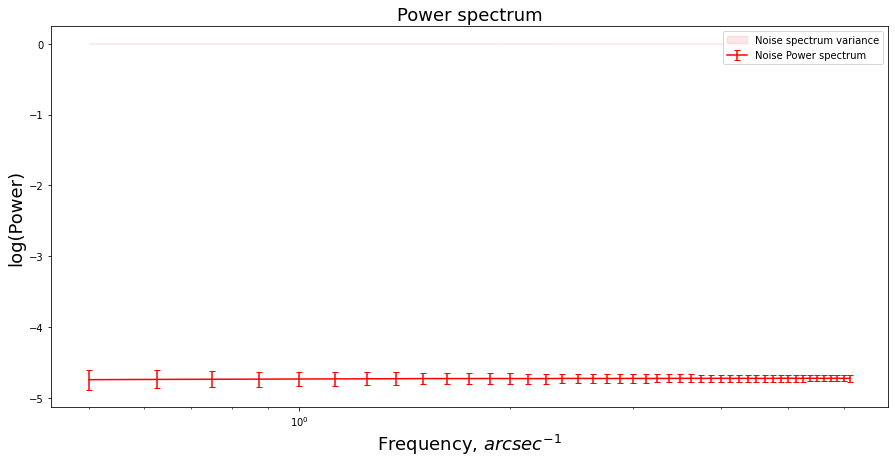

In [139]:
plt.figure(figsize=(15,7))

plt.fill_between(frequencies,Noise_spectra.min(axis=0),Noise_spectra.max(axis=0),color='r',alpha=0.1,label='Noise spectrum variance')
plt.errorbar(frequencies,Noise_mu,Noise_sigma,capsize=3,label='Noise Power spectrum',color='r')


plt.xscale('log')

plt.ylabel('log(Power)',fontsize=FS)
plt.xlabel('Frequency, '+r'$arcsec^{-1}$',fontsize=FS)
plt.title('Power spectrum',fontsize=FS)


plt.legend()
plt.show()

<bound method rv_continuous.cdf of <scipy.stats._continuous_distns.norm_gen object at 0x1273ced90>>

LogNormal2 fit failed
Normal fit failed


UnboundLocalError: local variable 'norm_distr' referenced before assignment

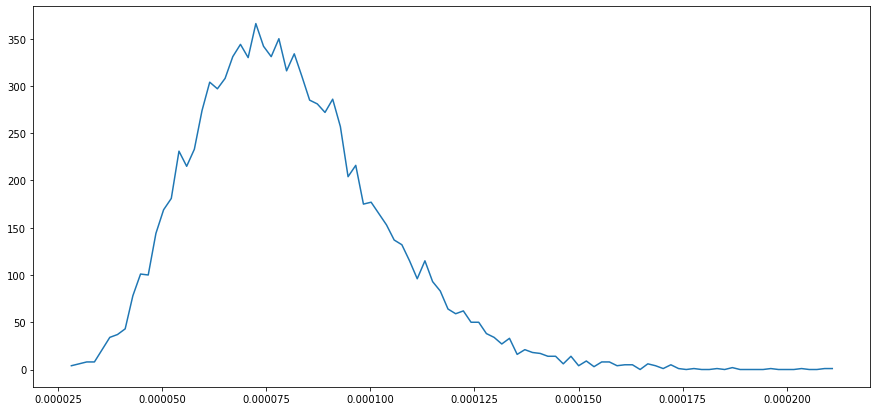

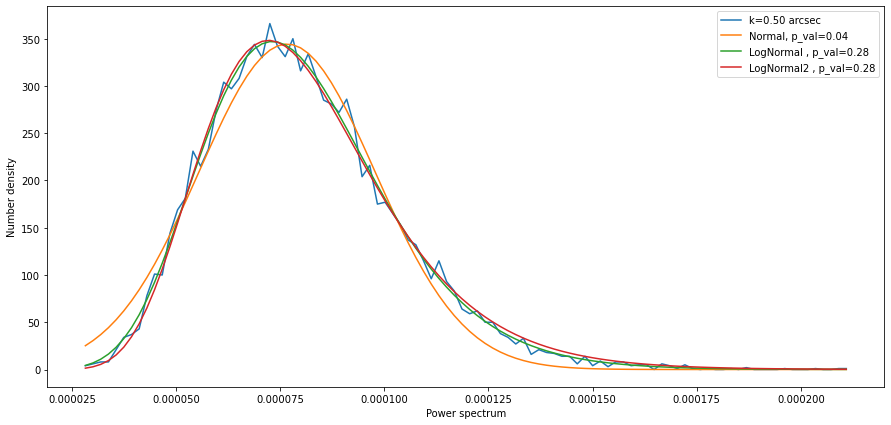

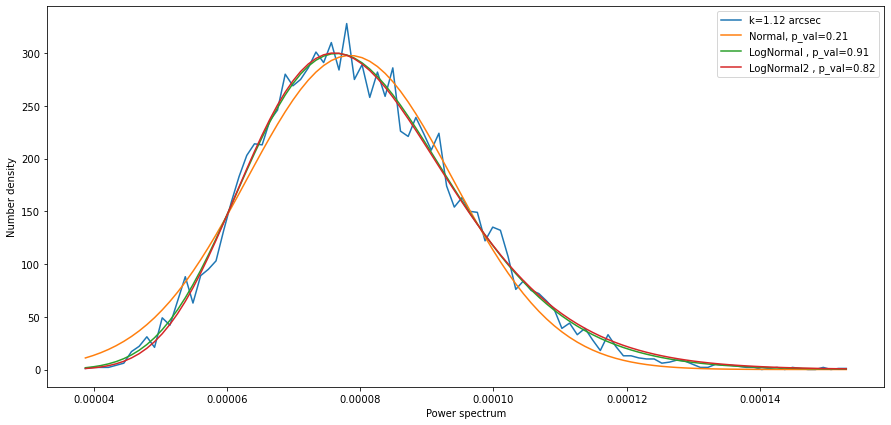

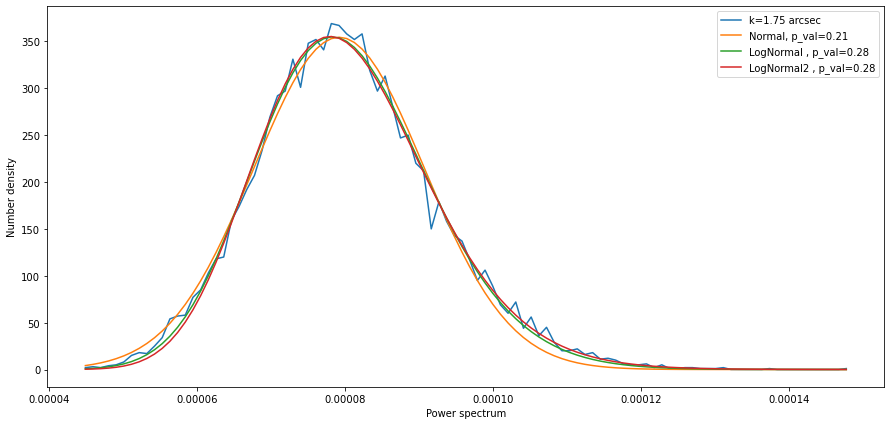

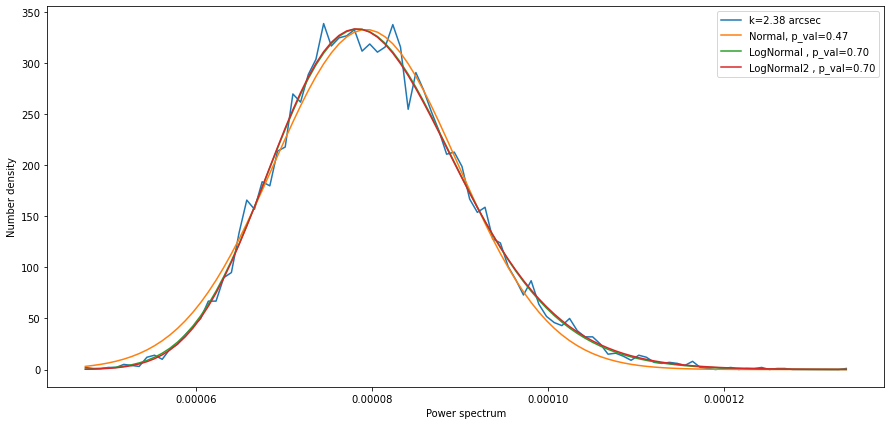

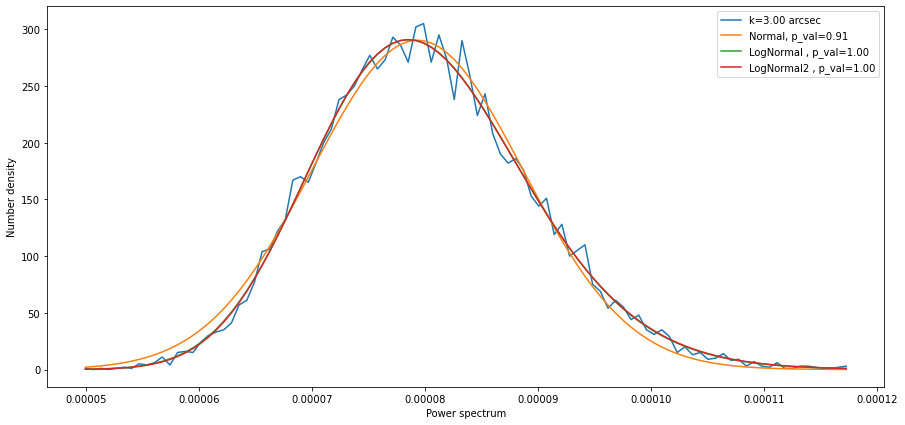

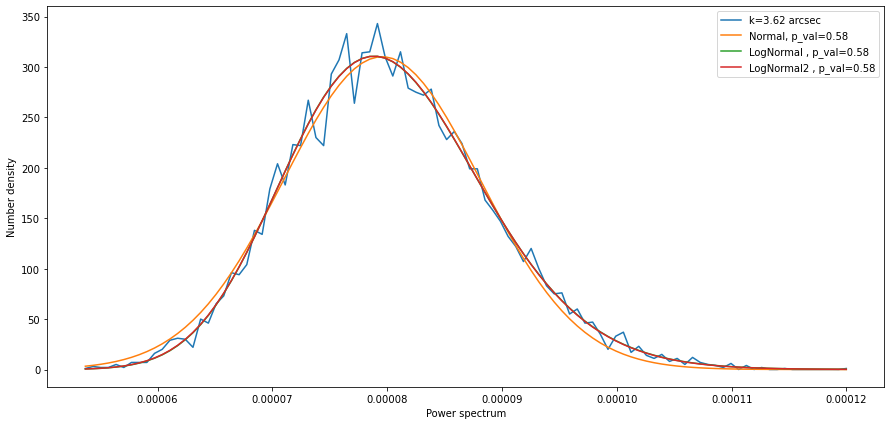

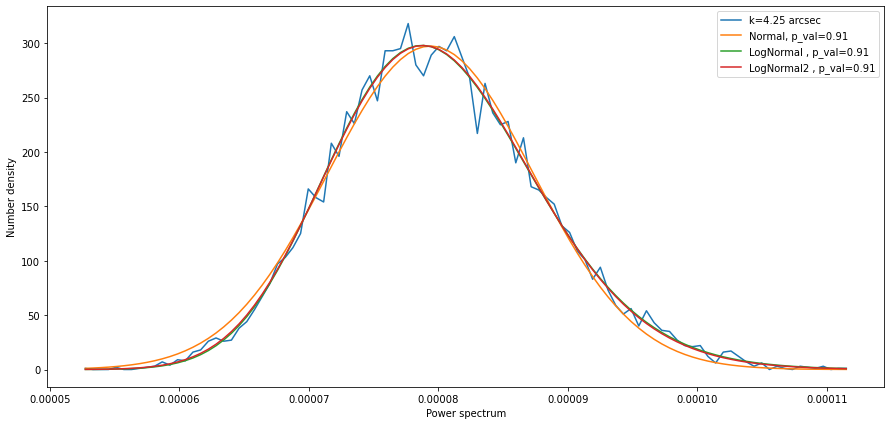

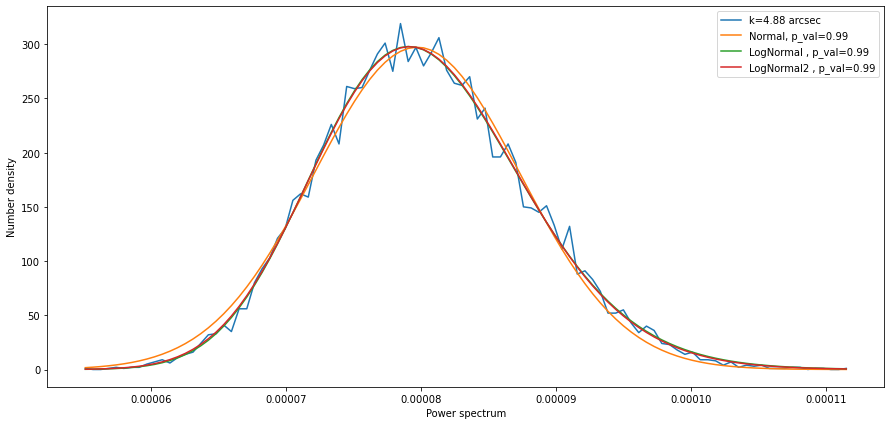

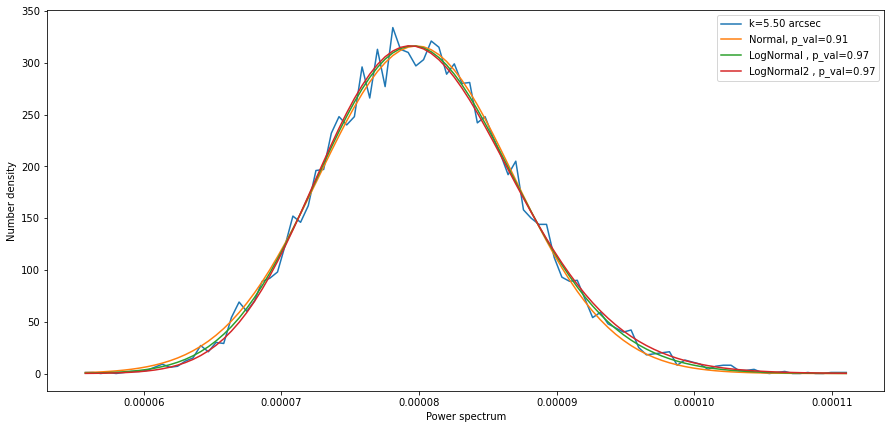

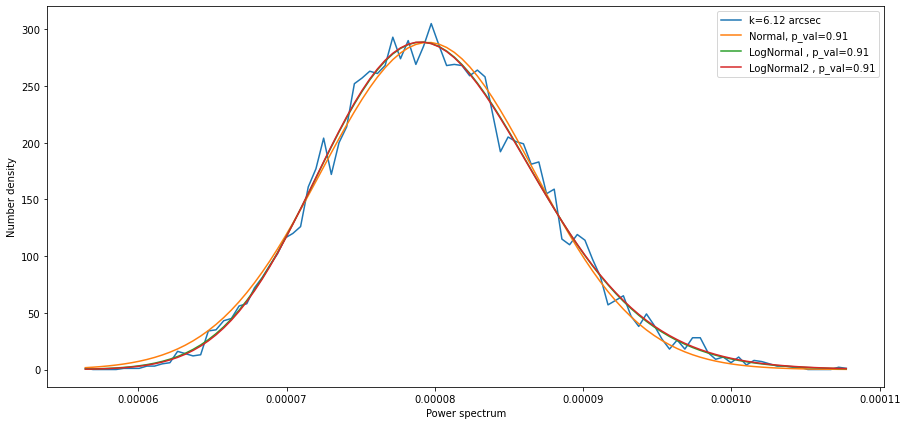

In [100]:
%matplotlib inline
for i in range(0,46,5):
    study_distribution(Noise_spectra,i,100)

In [ ]:
i=0



fig=plt.figure(figsize=(15,7))
data,x=np.histogram(np.sqrt(Noise_spectra[:,i]),bins=100)
    
lognorm_distr=lognormal(x[1:],*[1,Noise_sigma[i],0,np.exp(Noise_mu[i])])
lognorm_distr/=lognorm_distr.sum()
lognorm_distr*=data.sum()
  
try:
    popt=fit_likelihood(x[1:],data,distr_func='lognormal',Poisson_errs=False)
    norm_distr=lognormal(x[1:],*popt)
except:
    print('Normal fit failed')    

try:
    popt=fit_likelihood(x[1:],data,distr_func='normal',Poisson_errs=False)
    norm_distr=normal_distr(x[1:],*popt)
except:
    print('Normal fit failed')

    

plt.plot(x[1:],data,label='k={:.2f} arcsec'.format(frequencies[i]))
plt.plot(x[1:],norm_distr,label='Normal, p_val={:.2f}'.format(scipy.stats.ks_2samp(data,norm_distr)[1]))
plt.plot(x[1:],lognorm_distr,label='LogNormal , p_val={:.2f}'.format(scipy.stats.ks_2samp(data,lognorm_distr)[1]))
plt.legend()
plt.ylabel('Number density')
plt.xlabel('Power spectrum')
plt.title('Distribution of Noise Spectrum')
plt.show()

In [30]:
Spec_gamma,Spec_mu,Spec_sigma=infer_LogNorm_params(Res_Spectra)
Noise_gamma,Noise_mu,Noise_sigma=infer_LogNorm_params(Noise_spectra)

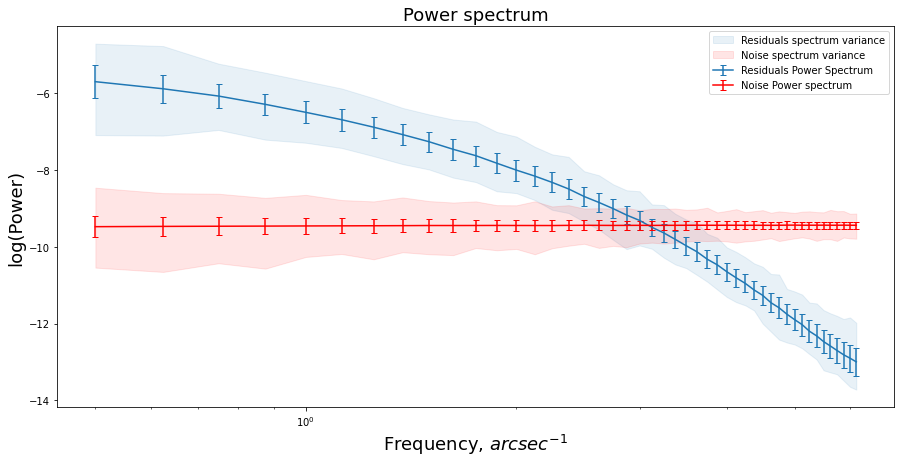

In [31]:
plt.figure(figsize=(15,7))

plt.errorbar(frequencies,Spec_mu,Spec_sigma,capsize=3,label='Residuals Power Spectrum',color='C0')
plt.fill_between(frequencies,np.log(Res_Spectra.min(axis=0)),np.log(Res_Spectra.max(axis=0)),color='C0',alpha=0.1,label='Residuals spectrum variance')

plt.fill_between(frequencies,np.log(Noise_spectra).min(axis=0),np.log(Noise_spectra).max(axis=0),color='r',alpha=0.1,label='Noise spectrum variance')
plt.errorbar(frequencies,Noise_mu,Noise_sigma,capsize=3,label='Noise Power spectrum',color='r')


plt.xscale('log')

plt.ylabel('log(Power)',fontsize=FS)
plt.xlabel('Frequency, '+r'$arcsec^{-1}$',fontsize=FS)
plt.title('Power spectrum',fontsize=FS)


plt.legend()
plt.show()

In [32]:
import scipy
def lognormal(xdata,*params):
    amplitude,s,loc,scale=params
    x=(xdata-loc)/scale
    return amplitude*scipy.stats.lognorm.pdf(x,s)

def normal_distr(xdata,*params):
    amplitude,mean,sigma=params
    
    return amplitude*np.exp(-(xdata-mean)**2/2/sigma**2)

def fit_likelihood(xdata,ydata,distr_func='lognormal',multiplier=None,Poisson_errs=False):
    
    #It is a trick to fit distributions in very small numbers here scipy just sets everyrhing to zero
    if multiplier:
        x=multiplier*xdata
    else:
        non_zero_xdata=xdata[np.where(xdata>0)[0]]
        multiplier=1/non_zero_xdata[0]
        x=multiplier*xdata
        
    if distr_func=='lognormal':
        func=lognormal
        init_guess=[1,1.,0.,1]
    elif distr_func=='normal':
        func=normal_distr
        init_guess=[1,x.mean(),x.std()]
    else:
        print('wrong distr_func')
        return None
    
        
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess,sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess)

    
    if distr_func=='lognormal':
        amplitude,s,loc,scale=popt
        return amplitude,s,loc/multiplier,scale/multiplier
    if distr_func=='normal':
        amplitude,mean,sigma=popt
        return amplitude,mean/multiplier,sigma/multiplier

In [43]:
Spec_gamma,Spec_mu,Spec_sigma=infer_LogNorm_params(np.sqrt(Res_Spectra))
Noise_gamma,Noise_mu,Noise_sigma=infer_LogNorm_params(np.sqrt(Noise_spectra))

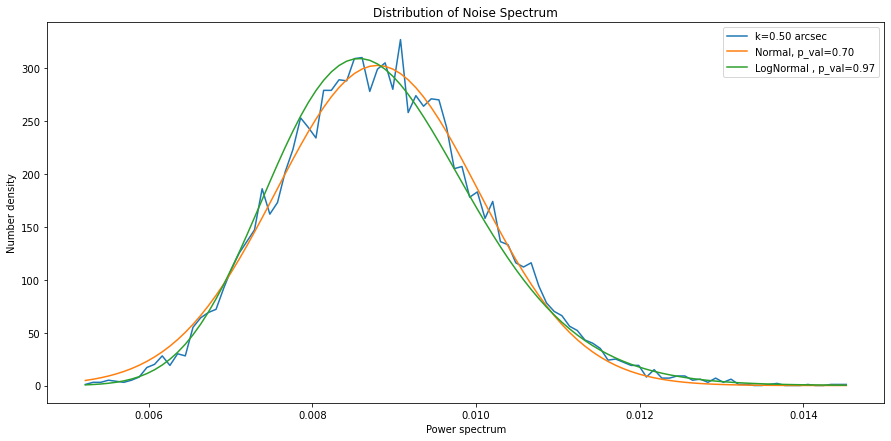

In [44]:
i=0

fig=plt.figure(figsize=(15,7))
data,x=np.histogram(np.sqrt(Noise_spectra[:,i]),bins=100)
    
lognorm_distr=lognormal(x[1:],*[1,Noise_sigma[i],0,np.exp(Noise_mu[i])])
lognorm_distr/=lognorm_distr.sum()
lognorm_distr*=data.sum()
    
try:
    popt=fit_likelihood(x[1:],data,distr_func='normal',Poisson_errs=False)
    norm_distr=normal_distr(x[1:],*popt)
except:
    print('Normal fit failed')

    

plt.plot(x[1:],data,label='k={:.2f} arcsec'.format(frequencies[i]))
plt.plot(x[1:],norm_distr,label='Normal, p_val={:.2f}'.format(scipy.stats.ks_2samp(data,norm_distr)[1]))
plt.plot(x[1:],lognorm_distr,label='LogNormal , p_val={:.2f}'.format(scipy.stats.ks_2samp(data,lognorm_distr)[1]))
plt.legend()
plt.ylabel('Number density')
plt.xlabel('Power spectrum')
plt.title('Distribution of Noise Spectrum')
plt.show()

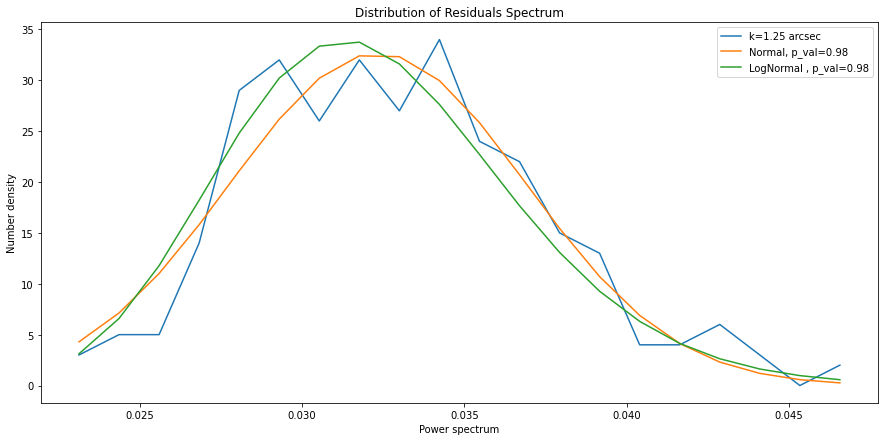

In [51]:
i=6

fig=plt.figure(figsize=(15,7))
data,x=np.histogram(np.sqrt(Res_Spectra[:,i]),bins=20)
    
lognorm_distr=lognormal(x[1:],*[1,Spec_sigma[i],0,np.exp(Spec_mu[i])])
lognorm_distr/=lognorm_distr.sum()
lognorm_distr*=data.sum()
    
try:
    popt=fit_likelihood(x[1:],data,distr_func='normal',Poisson_errs=False)
    norm_distr=normal_distr(x[1:],*popt)
except:
    print('Normal fit failed')

    

plt.plot(x[1:],data,label='k={:.2f} arcsec'.format(frequencies[i]))
plt.plot(x[1:],norm_distr,label='Normal, p_val={:.2f}'.format(scipy.stats.ks_2samp(data,norm_distr)[1]))
plt.plot(x[1:],lognorm_distr,label='LogNormal , p_val={:.2f}'.format(scipy.stats.ks_2samp(data,lognorm_distr)[1]))
plt.legend()
plt.ylabel('Number density')
plt.xlabel('Power spectrum')
plt.title('Distribution of Residuals Spectrum')
plt.show()

# Loss function

In [12]:
logSpec_data=np.log(true_spectrum)
sigma_data=Spec_sigma

@jax.jit
def Spectra_Loss_pure(model_spectra):
    
    #Infer mu of LogNormal distr
    mean=jnp.mean(model_spectra,axis=0)
    variance=jnp.power(jnp.std(model_spectra,axis=0),2)
    sigma_model=jnp.sqrt(jnp.log(1+variance/jnp.power(mean,2)))
    mu_model=jnp.log(mean)-jnp.power(sigma_model,2)/2
        
    #-LogLikelihood for Log Normal distribution    
    chi_sq=jnp.mean(jnp.power((logSpec_data-mu_model)/sigma_data,2))
    
    return chi_sq

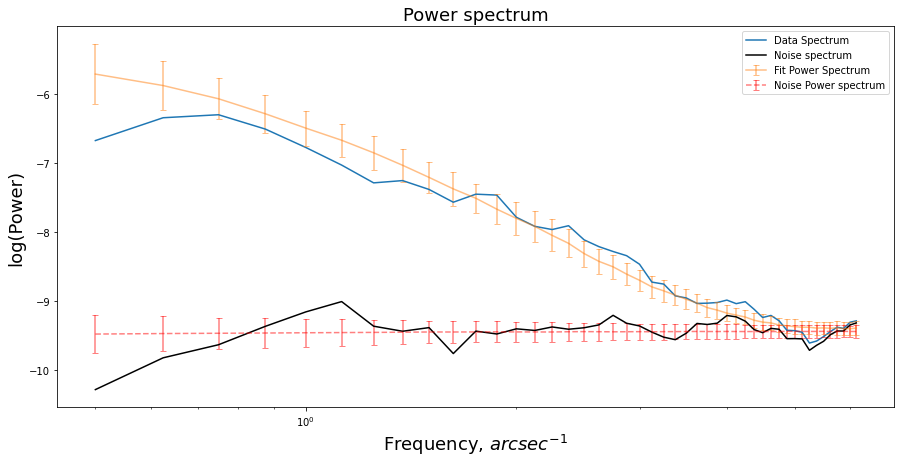

In [13]:
plt.figure(figsize=(15,7))

plt.plot(frequencies,logSpec_data,label='Data Spectrum')
plt.errorbar(frequencies,Spec_mu,Spec_sigma,capsize=3,label='Fit Power Spectrum',color='C1',alpha=0.5)

plt.errorbar(frequencies,Noise_mu,Noise_sigma,capsize=3,label='Noise Power spectrum',color='r',linestyle='--',alpha=0.5)
plt.plot(frequencies,np.log(true_noise_spectrum),label='Noise spectrum',color='k')



plt.xscale('log')

plt.ylabel('log(Power)',fontsize=FS)
plt.xlabel('Frequency, '+r'$arcsec^{-1}$',fontsize=FS)
plt.title('Power spectrum',fontsize=FS)


plt.legend()
plt.show()

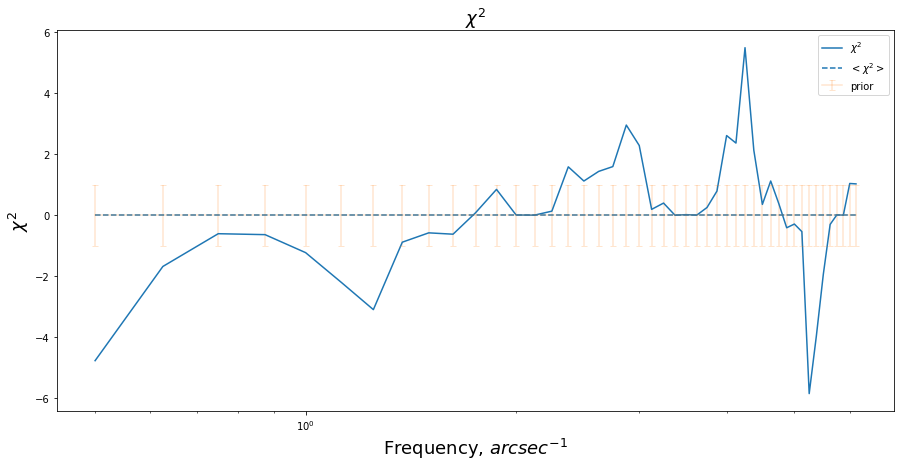

In [14]:
plt.figure(figsize=(15,7))

chisq=jnp.power((logSpec_data-Spec_mu)/sigma_data,2)*np.sign(logSpec_data-Spec_mu)
plt.plot(frequencies,chisq,label=r'$\chi^2$')
plt.plot(frequencies,chisq.mean()*np.ones_like(chisq),label=r'$<\chi^2>$',linestyle='--',color='C0')
#plt.hlines(chisq.mean(),frequencies[0],frequencies[-1],label=r'$<\chi^2>$',linestyle='--')
plt.errorbar(frequencies,np.zeros_like(frequencies),np.ones_like(frequencies),capsize=3,label='prior',color='C1',alpha=0.2)

plt.xscale('log')

plt.ylabel(r'$\chi^2$',fontsize=FS)
plt.xlabel('Frequency, '+r'$arcsec^{-1}$',fontsize=FS)
plt.title(r'$\chi^2$',fontsize=FS)


plt.legend()
plt.show()

# Differentiable loss

In [24]:
def GRF_Loss(GRF_params,GRF_seeds_number,Spectra_Loss_pure):

        GRF_seed_indices=np.arange(GRF_seeds_number)
        get_model_spectra=lambda GRF_seed_index: Inference.Residual_spectrum_for_GRF(GRF_params,GRF_seed_index)
        model_spectra=jax_map(get_model_spectra,GRF_seed_indices)

        Loss=Spectra_Loss_pure(model_spectra)
        return Loss
    

GRF_Loss_pure=jax.jit(lambda GRF_params: GRF_Loss(GRF_params,1,Spectra_Loss_pure))

In [25]:
start_time=time.time()
Loss=GRF_Loss_pure(GRF_params)
end_time=time.time()
print('Loss',Loss)
print('time',end_time-start_time)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=1/1)>
While tracing the function <lambda> at /Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Jax_Utils.py:68 for scan, this concrete value was not available in Python because it depends on the value of the argument 'x'.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [35]:
start_time=time.time()
Loss=GRF_Loss_pure(GRF_params)
end_time=time.time()
print('Loss',Loss)
print('time',end_time-start_time)

Loss 0.6787363636065923
time 13.765196084976196


In [36]:
start_time=time.time()
Grad_Loss=jax.grad(GRF_Loss_pure)(GRF_params)
end_time=time.time()
print('Grad Loss',Grad_Loss)
print('time',end_time-start_time)

Grad Loss [DeviceArray(2.39832766, dtype=float64), DeviceArray(-0.12386563, dtype=float64, weak_type=True)]
time 247.84498286247253
